In [ ]:
import os
import torch
import numpy as np
from torchvision import datasets
import torchvision
import torch.utils.data as tech 
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
from torch.autograd import Variable
from torch.autograd import Function
import torch.nn.functional as F
import torch.optim as optim
from torchpq.clustering import KMeans
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

/home/joeltech/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.manual_seed(0)
np.random.seed(0)

## MNIST dataset Exploration

In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

In [ ]:
print(train.data.shape)

torch.Size([60000, 28, 28])


In [ ]:
print(test.data.shape)

torch.Size([10000, 28, 28])


There are 60000 training and 10000 images of each 28x28 pixels in size.

In [ ]:
print("what is the type and minmax values of the unprocessed MNIST data?")
print(torch.max(train.data[0]))
print(torch.min(train.data[0]))

what is the type and minmax values of the unprocessed MNIST data?
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


In [ ]:
print("what is the type and minmax values of the processed(ToTensor() transform) MNIST data?")
print(torch.max(train[0][0]))
print(torch.min(train[0][0]))

what is the type and minmax values of the processed(ToTensor() transform) MNIST data?
tensor(1.)
tensor(0.)


We can see that the original images are of integer type with values ranging from 0 to 255. When loading the dataset, we have the normalized the values to floating type values ranging from 0.0 to 1.0 using the `torchvision.transforms.ToTensor()` transform.

Now, Let's visualize the first 10 images and their respective ground truth labels from the training dataset.

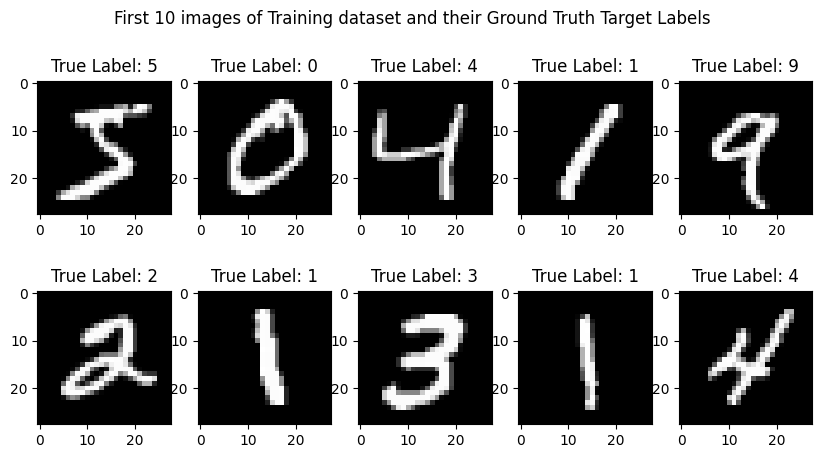

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("First 10 images of Training dataset and their Ground Truth Target Labels")
for i, ax in enumerate(axs.ravel()):
    ax.set_title("True Label: " + str(train.targets[i].item()))
    ax.imshow(train.data[i], cmap='gray')

That's interesting to see. 28x28 pixels seems a bit blurry, but probably enough to identify the digit.

Let's see the number of classes/digits and how many occurences of each in the training and test dataset.

In [ ]:
np.unique(train.targets.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [ ]:
np.unique(test.targets.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

So, there are 10 digits present from 0 to 9 as expected. The test set seems to be balanced with each digits having ~1000 samples. The train set also seems to be almost balanced with each digits having ~6000 samples, except for digit 1, there is 6742 samples, whereas digit 5 has only 5421. However, I hope 5000+ samples of any digit is probably good enough to generalize the model. Therefore, I think the training and test datasets are overall balanced and we are good to go. Let's start the training!

## Experiment 1: Let's Explore MLP, RBFNet and CNN while varying their number of parameters and seeing their effects on the performance

#### <b>Multi-Layer Perceptron (MLP) - 2 Hidden Layer</b>

Let's build a simple MLP network with 2 hidden layers

In [ ]:
class MultiLayerPerceptron2(nn.Module):   
    def __init__(self, input_size, num_classes):
        super(MultiLayerPerceptron2, self).__init__()

        self.MLP = nn.Sequential(
            nn.Linear(input_size, 350),
            nn.ReLU(inplace = True),
            nn.Linear(350, 100),
            nn.ReLU(inplace = True),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        return self.MLP(x)

In [ ]:
input_size = 28 * 28 # MNIST pixel dimension
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerPerceptron2(input_size, num_classes) 
model.to(device)

MultiLayerPerceptron2(
  (MLP): Sequential(
    (0): Linear(in_features=784, out_features=350, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=350, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
mlp2_batch_loss = []
mlp2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        mlp2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    mlp2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.21464568132773662
Epoch: 2 Loss: 0.09033823076827685
Epoch: 3 Loss: 0.06150251655867323
Epoch: 4 Loss: 0.04734959025062829
Epoch: 5 Loss: 0.03622133797003818
Epoch: 6 Loss: 0.03239888503712664
Epoch: 7 Loss: 0.024599118402916814
Epoch: 8 Loss: 0.022854042334111282
Epoch: 9 Loss: 0.020217744392925733
Epoch: 10 Loss: 0.0190061819479489
Epoch: 11 Loss: 0.017464415225891275
Epoch: 12 Loss: 0.016303322900343656
Epoch: 13 Loss: 0.017371662535399506
Epoch: 14 Loss: 0.015340029320937015
Epoch: 15 Loss: 0.01327557101317166
Epoch: 16 Loss: 0.01445332055026584
Epoch: 17 Loss: 0.0129252340625455
Epoch: 18 Loss: 0.013454801395939617
Epoch: 19 Loss: 0.010728559700804191
Epoch: 20 Loss: 0.014330360875084087
Training Time: 0:02:54.522273


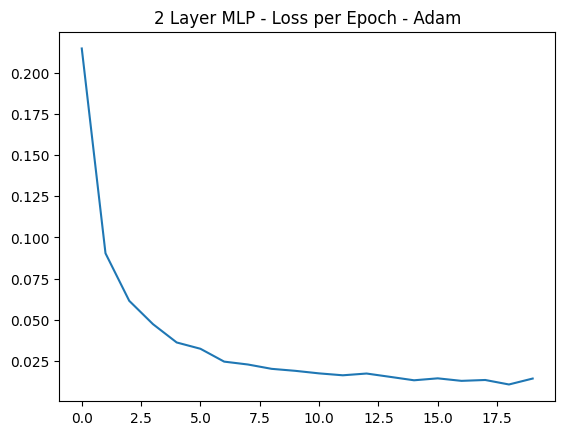

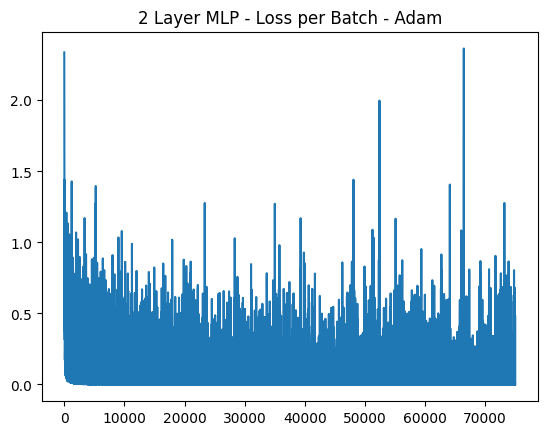

In [ ]:
plt.plot(mlp2_epoch_loss)
plt.title("2 Layer MLP - Loss per Epoch")
plt.show()
plt.plot(mlp2_batch_loss)
plt.title("2 Layer MLP - Loss per Batch")
plt.show()

Let's evaluate the performance of the model against the test dataset

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    # what is its label?
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

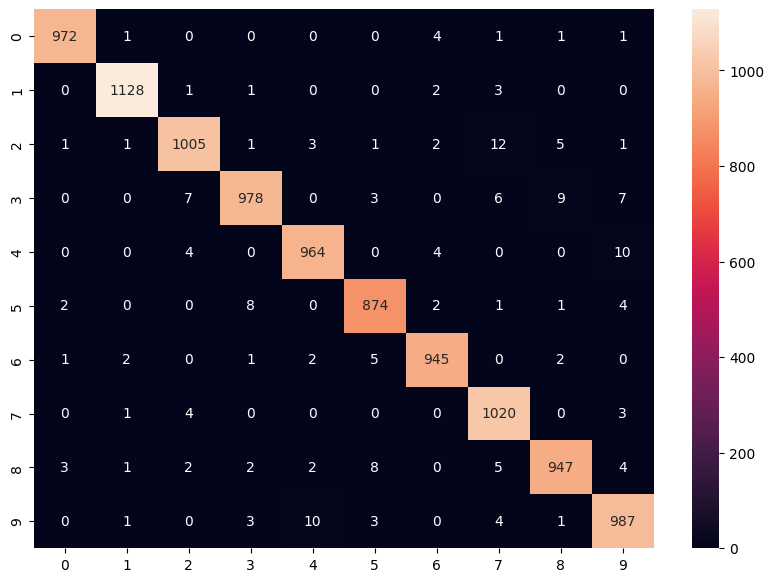

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.982

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9818526323148962

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9819105884761671

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9818437519839198

#### <b>Multi-Layer Perceptron (MLP) - 4 Hidden Layer</b>

Let's now build a deeper MLP network with 4 hidden layers

In [ ]:
class MultiLayerPerceptron4(nn.Module):   
    def __init__(self, input_size, num_classes):
        super(MultiLayerPerceptron4, self).__init__()

        self.MLP = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.MLP(x)

In [ ]:
input_size = 28 * 28 # MNIST pixel dimension
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerPerceptron4(input_size, num_classes) 
model.to(device)
model.train()

MultiLayerPerceptron4(
  (MLP): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
mlp4_batch_loss = []
mlp4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        mlp4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    mlp4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.24375036582450071
Epoch: 2 Loss: 0.10688353673680298
Epoch: 3 Loss: 0.07739596870029927
Epoch: 4 Loss: 0.06199395657266577
Epoch: 5 Loss: 0.050888717706039824
Epoch: 6 Loss: 0.04187720770456253
Epoch: 7 Loss: 0.03843690803995925
Epoch: 8 Loss: 0.03340686849074696
Epoch: 9 Loss: 0.029905701405168628
Epoch: 10 Loss: 0.028880996259549086
Epoch: 11 Loss: 0.024946939187320296
Epoch: 12 Loss: 0.02579064715251775
Epoch: 13 Loss: 0.0231533436871873
Epoch: 14 Loss: 0.019774962424512224
Epoch: 15 Loss: 0.021741270265231368
Epoch: 16 Loss: 0.022103208797028148
Epoch: 17 Loss: 0.019082729077153464
Epoch: 18 Loss: 0.020102664118871974
Epoch: 19 Loss: 0.017991427225889277
Epoch: 20 Loss: 0.015401063181648161
Training Time: 0:03:57.189379


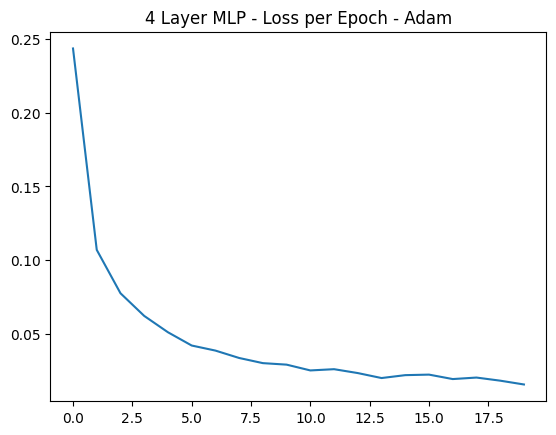

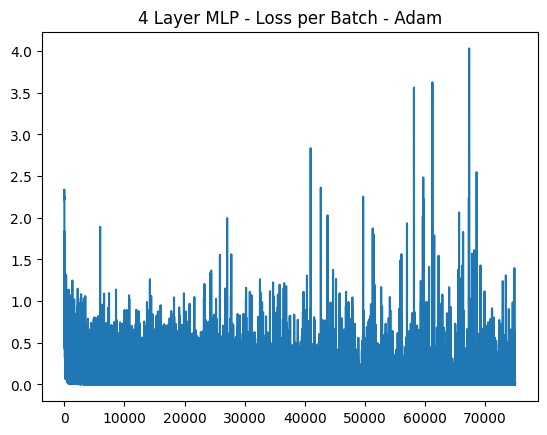

In [ ]:
plt.plot(mlp4_epoch_loss)
plt.title("4 Layer MLP - Loss per Epoch")
plt.show()
plt.plot(mlp4_batch_loss)
plt.title("4 Layer MLP - Loss per Batch")
plt.show()

Let's evaluate the performance of the model against the test dataset

In [ ]:
model.eval()
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

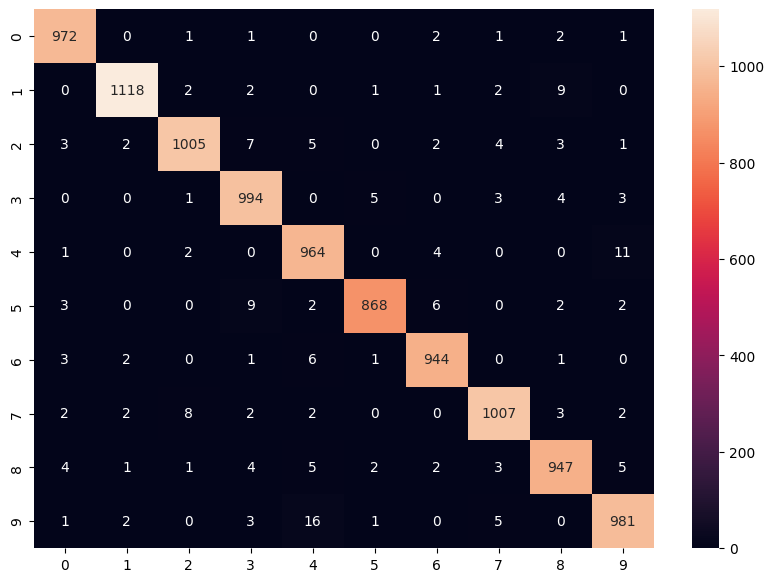

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.98

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9799077441280953

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9799563153614281

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.979910583651327

#### <b>Vectorized RBF Net</b>

In [ ]:
# make network
class RBFnet(nn.Module):
    def __init__(self, clusters, num_classes, device):
        super(RBFnet, self).__init__()
        # remember how many centers we have
        self.N = clusters.shape[0]
        # our mean and sigmas for the RBF layer
        self.sigs = nn.Parameter( torch.ones(self.N, dtype=torch.float64, device=device)*5, requires_grad=False) # our sigmas
        self.mus = nn.Parameter( torch.from_numpy(clusters).to(device), requires_grad=False) # our means
        self.linear = nn.Linear(self.N, num_classes, dtype=torch.float64)
    
    def forward(self, x):
        # Vectorized Version - Pretty Fast
        #--------------------------------------------------------------------------
        size = (x.size(0), self.N, x.size(1)) # (batch_size, number_of_clusters or rbfs, input_image_size=28x28=784) 
        x = x.unsqueeze(1).expand(size)
        c = self.mus.unsqueeze(0).expand(size)
        top = (x - c).pow(2).sum(-1).pow(0.5)
        res = (-0.5*(top.pow(2) / self.sigs.pow(2))).exp()
        y_pred = self.linear(res)
        return y_pred

#### <b>RBF Net - 50 RBF nodes</b>

In [ ]:
number_of_rbf = 50

In [ ]:
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)
print(xtrain.shape)

(60000, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kmeans = KMeans(n_clusters=number_of_rbf, distance="euclidean")
x = torch.from_numpy(xtrain.T).to(device)
y = torch.from_numpy(ytrain.T).to(device)
kmeans.fit(x.contiguous())
clusters = kmeans.centroids.T.cpu().numpy()
print(clusters.shape)

(50, 784)


In [ ]:
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet(clusters, num_classes, device)
model.to(device)

RBFnet(
  (linear): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf50_batch_loss = []
rbf50_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf50_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf50_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 1.602827140074564
Epoch: 2 Loss: 1.0204271158930105
Epoch: 3 Loss: 0.8174895786189889
Epoch: 4 Loss: 0.7144639073384927
Epoch: 5 Loss: 0.6519323538745594
Epoch: 6 Loss: 0.6094719671128243
Epoch: 7 Loss: 0.578651065179506
Epoch: 8 Loss: 0.5542517682338562
Epoch: 9 Loss: 0.5352056915849825
Epoch: 10 Loss: 0.5193433199431173
Epoch: 11 Loss: 0.5061285184419237
Epoch: 12 Loss: 0.49457685522063066
Epoch: 13 Loss: 0.48460076650135736
Epoch: 14 Loss: 0.4760628702609856
Epoch: 15 Loss: 0.4681857814390931
Epoch: 16 Loss: 0.46130684856337206
Epoch: 17 Loss: 0.4548843475124247
Epoch: 18 Loss: 0.4489966760529364
Epoch: 19 Loss: 0.4438667350592918
Epoch: 20 Loss: 0.43879093014070564
Training Time: 0:02:40.532620


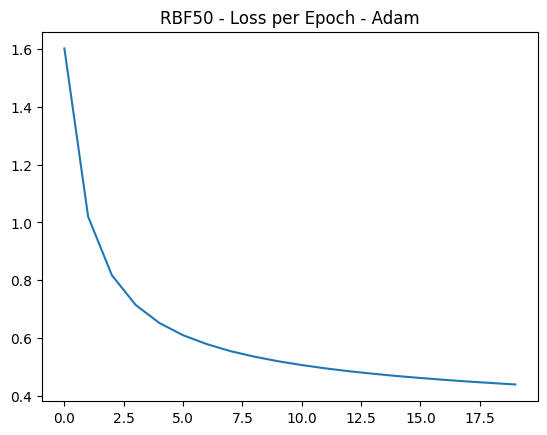

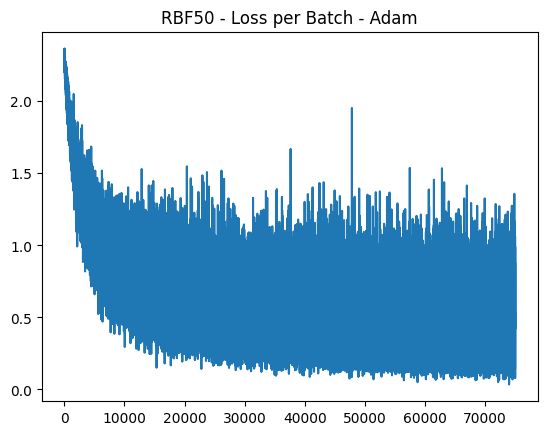

In [ ]:
plt.plot(rbf50_epoch_loss)
plt.title("RBF50 - Loss per Epoch")
plt.show()
plt.plot(rbf50_batch_loss)
plt.title("RBF50 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

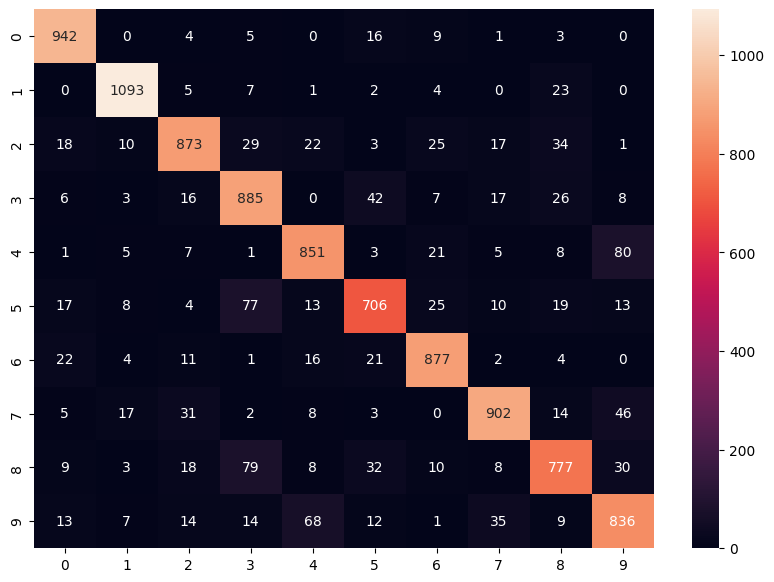

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.8742

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.8722265890706773

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.8729981901428306

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.8723631682943969

#### <b>RBF Net - 100 RBF nodes</b>

In [ ]:
number_of_rbf = 100

In [ ]:
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kmeans = KMeans(n_clusters=number_of_rbf, distance="euclidean")
x = torch.from_numpy(xtrain.T).to(device)
y = torch.from_numpy(ytrain.T).to(device)
kmeans.fit(x.contiguous())
clusters = kmeans.centroids.T.cpu().numpy()
print(clusters.shape)

(100, 784)


In [ ]:
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet(clusters, num_classes, device)
model.to(device)

RBFnet(
  (linear): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf100_batch_loss = []
rbf100_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf100_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf100_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 1.3165203513726416
Epoch: 2 Loss: 0.7606048696379342
Epoch: 3 Loss: 0.6161434634350298
Epoch: 4 Loss: 0.5463860289035788
Epoch: 5 Loss: 0.5043207481488535
Epoch: 6 Loss: 0.4757622964381356
Epoch: 7 Loss: 0.45475175844485854
Epoch: 8 Loss: 0.4381667950011587
Epoch: 9 Loss: 0.4246690716450923
Epoch: 10 Loss: 0.41375589305629157
Epoch: 11 Loss: 0.40421519170337783
Epoch: 12 Loss: 0.3962944534363278
Epoch: 13 Loss: 0.3892131738982157
Epoch: 14 Loss: 0.38289588650182554
Epoch: 15 Loss: 0.37728263465465756
Epoch: 16 Loss: 0.3721575505235949
Epoch: 17 Loss: 0.3671045172558579
Epoch: 18 Loss: 0.3629889395269757
Epoch: 19 Loss: 0.3590375904244476
Epoch: 20 Loss: 0.35544619111831566
Training Time: 0:02:39.028993


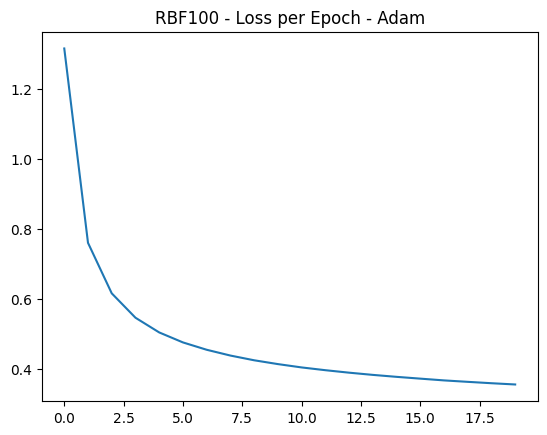

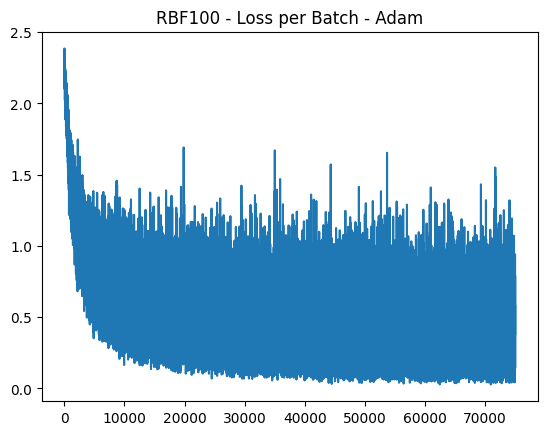

In [ ]:
plt.plot(rbf100_epoch_loss)
plt.title("RBF100 - Loss per Epoch")
plt.show()
plt.plot(rbf100_batch_loss)
plt.title("RBF100 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

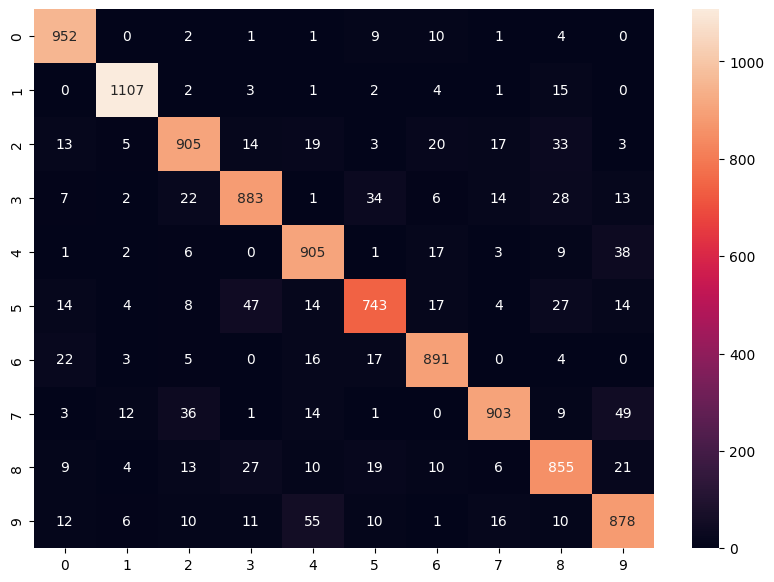

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9022

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9007083181920121

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9012083197848237

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9008961806115604

#### <b>RBF 2 Layer Net - 100 + 50 RBF Nodes</b>

In [ ]:
# make network
class RBFnet2Layer(nn.Module):
    def __init__(self, clusters1, num_layer1_linear_nodes, num_cluster2, num_classes, device):
        super(RBFnet2Layer, self).__init__()
        # remember how many centers we have
        self.N1 = clusters1.shape[0]
        self.N2 = num_cluster2
        self.num_layer1_linear_nodes = num_layer1_linear_nodes
        self.num_classes = num_classes
        
        # our mean and sigmas for the RBF layer 1
        self.sigs1 = nn.Parameter( torch.ones(self.N1, dtype=torch.float64, device=device)*5, requires_grad=False) # our sigmas
        self.mus1 = nn.Parameter( torch.from_numpy(clusters1).to(device), requires_grad=False) # our means
        self.linear1 = nn.Linear(self.N1, num_layer1_linear_nodes, dtype=torch.float64)
        
        # our mean and sigmas for the RBF layer 2
        self.sigs2 = nn.Parameter(torch.ones(self.N2, dtype=torch.float64, device=device)*5, requires_grad=False) # our sigmas
        # the input to 2nd RBF is not from our data, its rather from the linear layer1, therefore we cant precompute kmeans centers for layer2 rbf
        # therefore we initialize the centers as a normal distribution between 0 and 1
        self.mus2 = nn.Parameter(torch.normal(0, 1, size=(self.N2, num_layer1_linear_nodes))) 
        self.linear2 = nn.Linear(self.N2, num_classes, dtype=torch.float64)
    
    def forward(self, x):
        # Vectorized Version - Pretty Fast
        #--------------------------------------------------------------------------
        size1 = (x.size(0), self.N1, x.size(1)) # (batch_size, number_of_rbf_layer1, input_image_size=28x28=784) 
        size2 = (x.size(0), self.N2, self.num_layer1_linear_nodes) # (batch_size, number_of_rbf_layer2, linear1_output)

        
        c1 = self.mus1.unsqueeze(0).expand(size1)
        c2 = self.mus2.unsqueeze(0).expand(size2)

        x = x.unsqueeze(1).expand(size1)
        top1 = (x - c1).pow(2).sum(-1).pow(0.5)
        res1 = (-0.5*(top1.pow(2) / self.sigs1.pow(2))).exp()
        layer1_out = self.linear1(res1)
        
        layer1_out = layer1_out.unsqueeze(1).expand(size2)
        top2 = (layer1_out - c2).pow(2).sum(-1).pow(0.5)
        res2 = (-0.5*(top2.pow(2) / self.sigs2.pow(2))).exp()
        y_pred = self.linear2(res2)
        
        return y_pred

In [ ]:
number_of_rbf1 = 100
num_layer1_linear_nodes = 75
number_of_rbf2 = 50
num_classes = 10 # we have 10 classes in MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)
x = torch.from_numpy(xtrain.T).to(device).contiguous()
y = torch.from_numpy(ytrain.T).to(device).contiguous()

In [ ]:
kmeans = KMeans(n_clusters=number_of_rbf1, distance="euclidean")
kmeans.fit(x)
clusters1 = kmeans.centroids.T.cpu().numpy()
print(clusters1.shape)

(100, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet2Layer(clusters1, num_layer1_linear_nodes, number_of_rbf2, num_classes, device)
model.to(device)

RBFnet2Layer(
  (linear1): Linear(in_features=100, out_features=75, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf_batch_loss = []
rbf_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 1.1684003549165836
Epoch: 2 Loss: 0.5424524239015796
Epoch: 3 Loss: 0.4344697034024116
Epoch: 4 Loss: 0.38681628273001756
Epoch: 5 Loss: 0.36045833859039156
Epoch: 6 Loss: 0.34192253134302397
Epoch: 7 Loss: 0.3276384960546763
Epoch: 8 Loss: 0.318242081252507
Epoch: 9 Loss: 0.3084417895665569
Epoch: 10 Loss: 0.300520751567569
Epoch: 11 Loss: 0.2938808389395878
Epoch: 12 Loss: 0.2875818360345776
Epoch: 13 Loss: 0.28257750700197787
Epoch: 14 Loss: 0.27832440946345616
Epoch: 15 Loss: 0.2727112701608574
Epoch: 16 Loss: 0.26842370341253163
Epoch: 17 Loss: 0.26495659264583976
Epoch: 18 Loss: 0.2602278542674614
Epoch: 19 Loss: 0.25703594958123543
Epoch: 20 Loss: 0.2534043253442911
Training Time: 0:03:19.296626


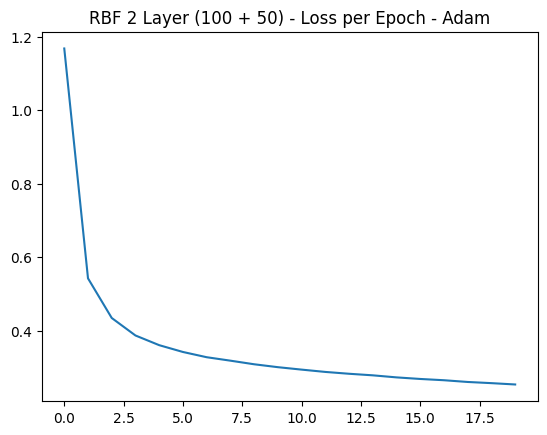

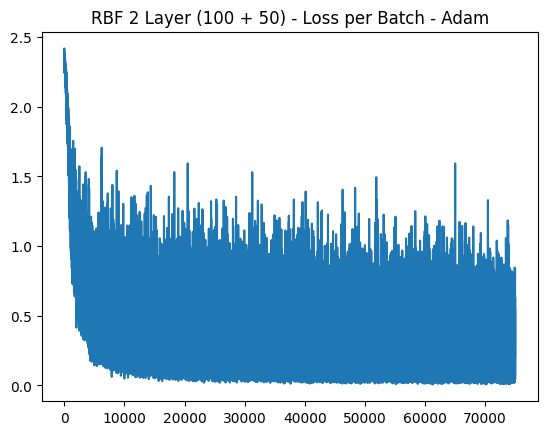

In [ ]:
plt.plot(rbf_epoch_loss)
plt.title("RBF 2 Layer (100 + 50) - Loss per Epoch")
plt.show()
plt.plot(rbf_batch_loss)
plt.title("RBF 2 Layer (100 + 50) - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

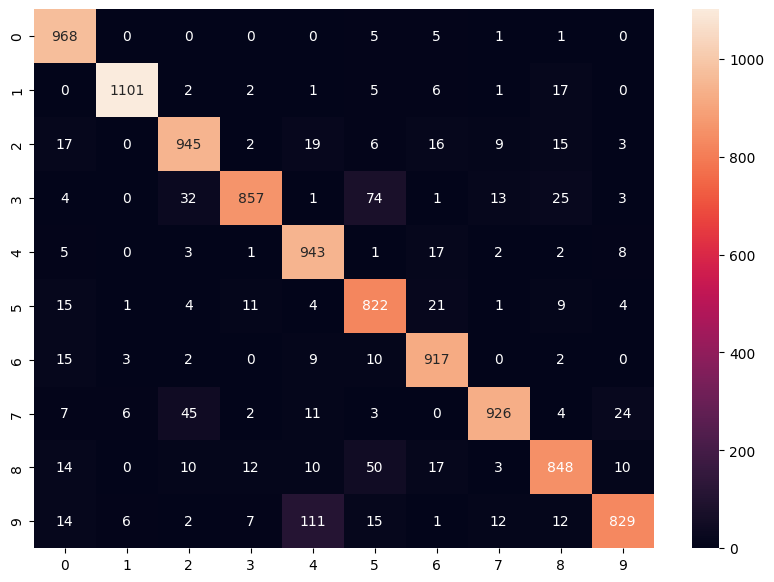

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9156

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.914221418299275

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9163069298126064

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.915404429256153

#### <b>CNN - 2 layers</b>

In [ ]:
class CNN2(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 4, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 4, out_channels = 8, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(8*(14*14), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2(input_channel_size, num_classes)
model.to(device)

CNN2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.23368388932316253
Epoch: 2 Loss: 0.09798383578069819
Epoch: 3 Loss: 0.0770550170351984
Epoch: 4 Loss: 0.06308340364599911
Epoch: 5 Loss: 0.056878062946801464
Epoch: 6 Loss: 0.050735938841097714
Epoch: 7 Loss: 0.04764674860756786
Epoch: 8 Loss: 0.0447029668947934
Epoch: 9 Loss: 0.041616752297641266
Epoch: 10 Loss: 0.03942103979955476
Epoch: 11 Loss: 0.035912335607205026
Epoch: 12 Loss: 0.03508184388348794
Epoch: 13 Loss: 0.0340601269115803
Epoch: 14 Loss: 0.03235233716185758
Epoch: 15 Loss: 0.030499348033862287
Epoch: 16 Loss: 0.029931233959561845
Epoch: 17 Loss: 0.029318541262540868
Epoch: 18 Loss: 0.0290262477367373
Epoch: 19 Loss: 0.027011175558226266
Epoch: 20 Loss: 0.02645393951231093
Training Time: 0:03:45.651511


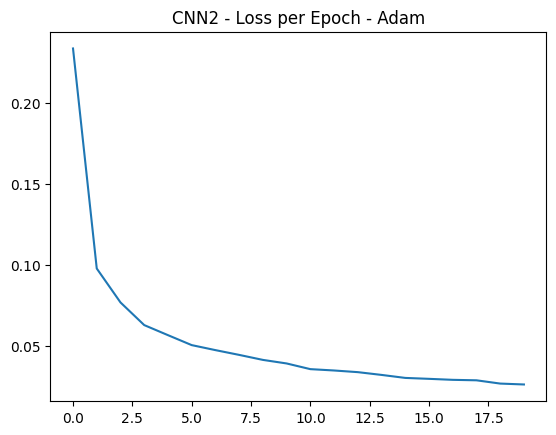

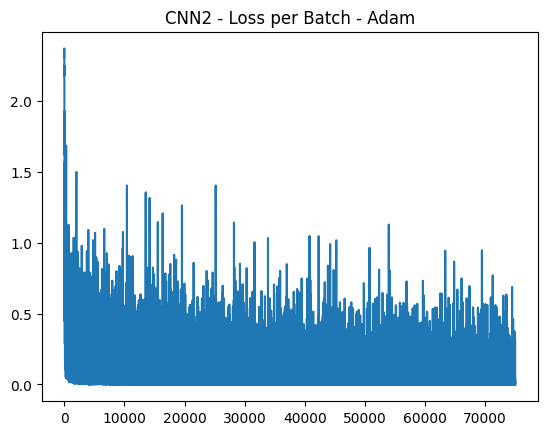

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

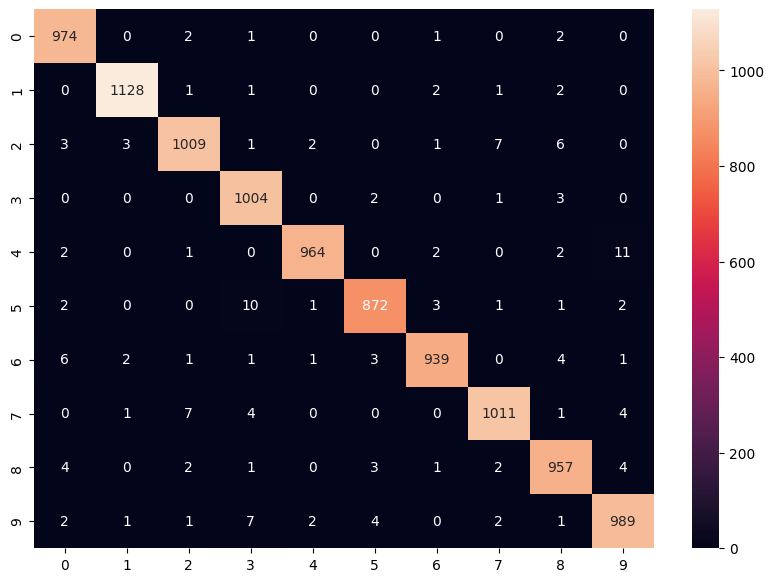

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9847

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9845611332316533

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9846618790433601

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9845085916125855

#### <b>CNN - 4 layers</b>

In [ ]:
class CNN4(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN4, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 8, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 8, out_channels = 16, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            
            # Max Pool and Dropout
            nn.MaxPool2d(2), 
            nn.Dropout(0.1),

            # Convolutional Layer 3
            nn.Conv2d( in_channels = 16, out_channels = 32, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.Conv2d( in_channels = 32, out_channels = 64, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
        )
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(64*(14*14), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4(input_channel_size, num_classes)
model.to(device)

CNN4(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.13659205674797412
Epoch: 2 Loss: 0.04822276074130253
Epoch: 3 Loss: 0.0345813859573888
Epoch: 4 Loss: 0.02524564840602249
Epoch: 5 Loss: 0.019617412962489433
Epoch: 6 Loss: 0.016690154449846315
Epoch: 7 Loss: 0.014305777788097614
Epoch: 8 Loss: 0.011512009531439204
Epoch: 9 Loss: 0.011561727155897355
Epoch: 10 Loss: 0.008641606814281666
Epoch: 11 Loss: 0.00943758791621182
Epoch: 12 Loss: 0.006828620148505811
Epoch: 13 Loss: 0.008807937334583717
Epoch: 14 Loss: 0.007352771255637065
Epoch: 15 Loss: 0.006434574672073099
Epoch: 16 Loss: 0.006526817825528681
Epoch: 17 Loss: 0.005801569652559046
Epoch: 18 Loss: 0.006656107772990983
Epoch: 19 Loss: 0.006569814132217531
Epoch: 20 Loss: 0.005540115759887793
Training Time: 0:04:28.507280


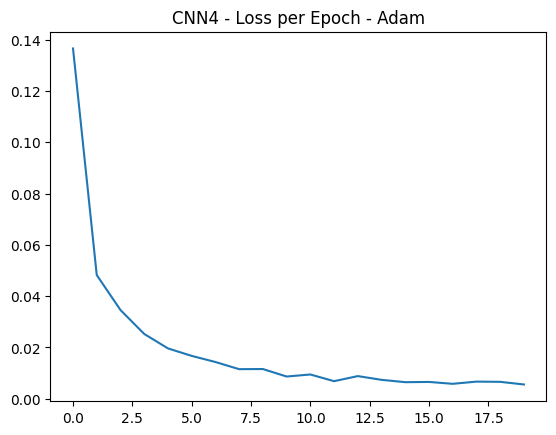

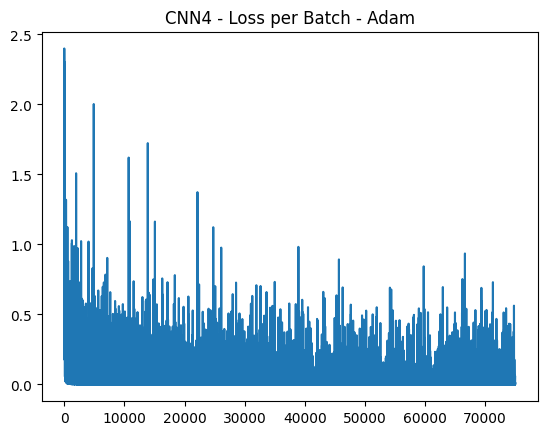

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

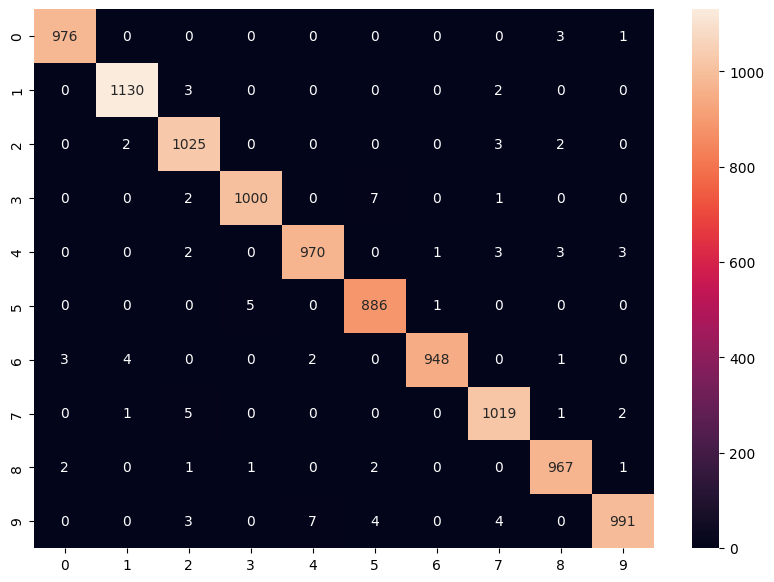

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9912

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9911641052149669

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9911807385513246

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9911663148016313

## Experiment 2: Let's Explore the effects of using different optimizer with respect to time and performance

#### **SGD - MLP 4 Layer**



In [ ]:
input_size = 28 * 28 # MNIST pixel dimension
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerPerceptron4(input_size, num_classes) 
model.to(device)

MultiLayerPerceptron4(
  (MLP): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
mlp4_batch_loss = []
mlp4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        mlp4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    mlp4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 2.3023576175053915
Epoch: 2 Loss: 2.291764730262756
Epoch: 3 Loss: 2.2703070063273114
Epoch: 4 Loss: 2.166297183386485
Epoch: 5 Loss: 1.6925118994235993
Epoch: 6 Loss: 1.0974549350182214
Epoch: 7 Loss: 0.8219816114425659
Epoch: 8 Loss: 0.6426886950492859
Epoch: 9 Loss: 0.5429356347461541
Epoch: 10 Loss: 0.4731885671605667
Epoch: 11 Loss: 0.41980687022109825
Epoch: 12 Loss: 0.3763936580230792
Epoch: 13 Loss: 0.34130515772302944
Epoch: 14 Loss: 0.3105289007375638
Epoch: 15 Loss: 0.28460776959309975
Epoch: 16 Loss: 0.26210026289746163
Epoch: 17 Loss: 0.24216962778419257
Epoch: 18 Loss: 0.22409707119291028
Epoch: 19 Loss: 0.20767245711808402
Epoch: 20 Loss: 0.19322256171827515
Training Time: 0:02:52.049436


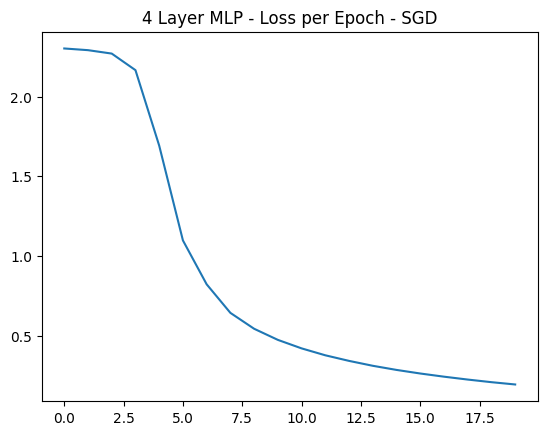

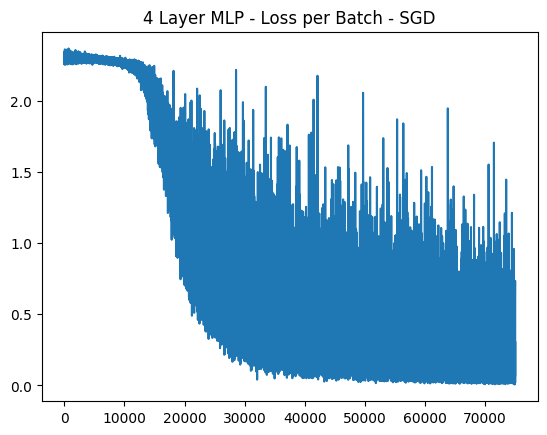

In [ ]:
plt.plot(mlp4_epoch_loss)
plt.title("4 Layer MLP - Loss per Epoch")
plt.show()
plt.plot(mlp4_batch_loss)
plt.title("4 Layer MLP - Loss per Batch")
plt.show()

Let's evaluate the performance of the model against the test dataset

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

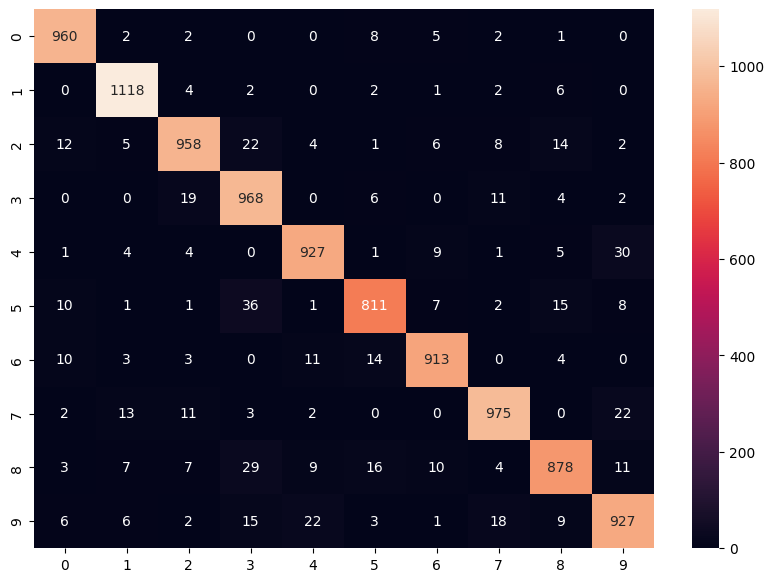

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9435

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9428538079902126

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9434768778057091

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9426148465415893

#### **SGD - RBF 2 Layer (100 + 50)**

In [ ]:
number_of_rbf1 = 100
num_layer1_linear_nodes = 75
number_of_rbf2 = 50
num_classes = 10 # we have 10 classes in MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)
x = torch.from_numpy(xtrain.T).to(device).contiguous()
y = torch.from_numpy(ytrain.T).to(device).contiguous()

In [ ]:
kmeans = KMeans(n_clusters=number_of_rbf1, distance="euclidean")
kmeans.fit(x)
clusters1 = kmeans.centroids.T.cpu().numpy()
print(clusters1.shape)

(100, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet2Layer(clusters1, num_layer1_linear_nodes, number_of_rbf2, num_classes, device)
model.to(device)

RBFnet2Layer(
  (linear1): Linear(in_features=100, out_features=75, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf_batch_loss = []
rbf_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 2.3350466646773227
Epoch: 2 Loss: 2.3025554798501666
Epoch: 3 Loss: 2.3010133546997573
Epoch: 4 Loss: 2.3007034859639495
Epoch: 5 Loss: 2.3004464339358908
Epoch: 6 Loss: 2.300197514739774
Epoch: 7 Loss: 2.2999286206305993
Epoch: 8 Loss: 2.299667178870328
Epoch: 9 Loss: 2.299378589863304
Epoch: 10 Loss: 2.2991020956015857
Epoch: 11 Loss: 2.298781747439306
Epoch: 12 Loss: 2.2984440720435795
Epoch: 13 Loss: 2.298112433960374
Epoch: 14 Loss: 2.297745951242755
Epoch: 15 Loss: 2.2973509907689995
Epoch: 16 Loss: 2.2969232287613446
Epoch: 17 Loss: 2.2964501195254385
Epoch: 18 Loss: 2.2959552378916777
Epoch: 19 Loss: 2.2954024587614277
Epoch: 20 Loss: 2.294813554988574
Training Time: 0:02:56.765888


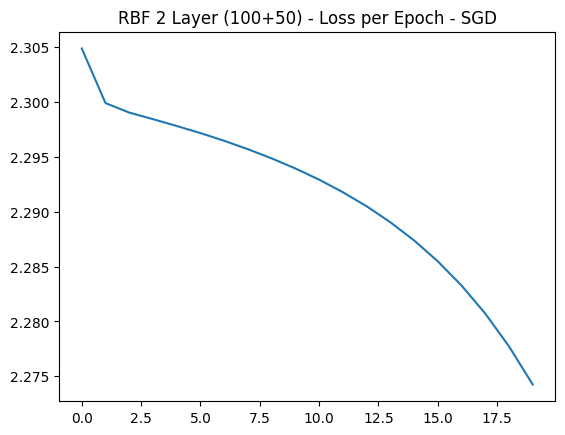

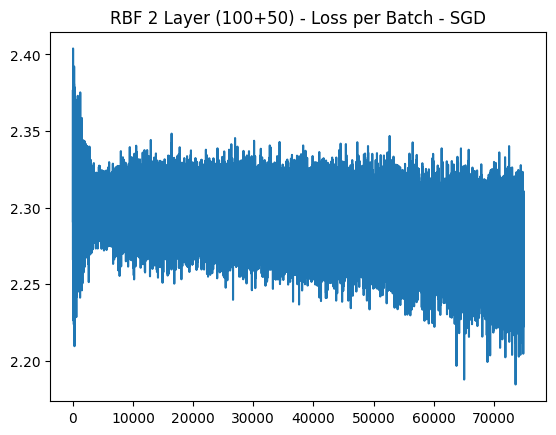

In [ ]:
plt.plot(rbf_epoch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Epoch")
plt.show()
plt.plot(rbf_batch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

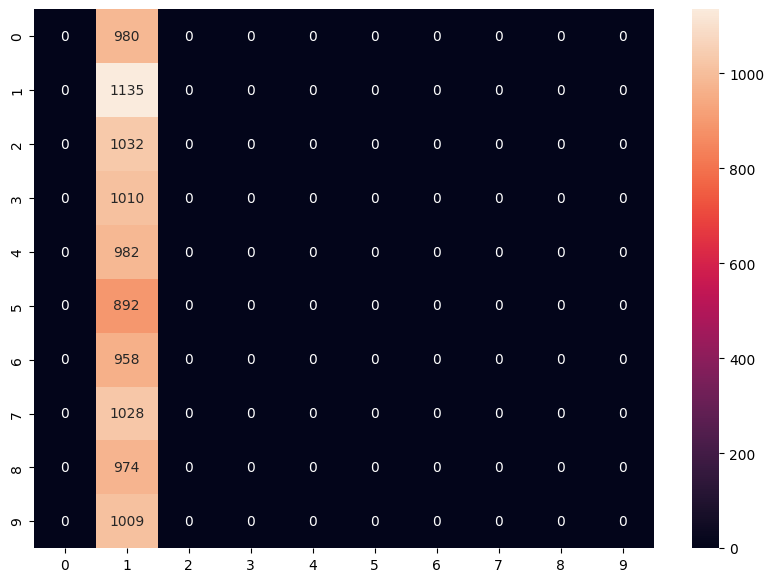

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.1135

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.0203861697350696

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

/home/joeltech/micromamba/envs/nn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.01135

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.1

#### **SGD - CNN 4 Layer**

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4(input_channel_size, num_classes)
model.to(device)

CNN4(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 1.5303033792277176
Epoch: 2 Loss: 0.3896038682371378
Epoch: 3 Loss: 0.2919420824252069
Epoch: 4 Loss: 0.20833696878651778
Epoch: 5 Loss: 0.15740289094224572
Epoch: 6 Loss: 0.13112224996446942
Epoch: 7 Loss: 0.11543588968268596
Epoch: 8 Loss: 0.10374907787684351
Epoch: 9 Loss: 0.09558523400191528
Epoch: 10 Loss: 0.08825176166804352
Epoch: 11 Loss: 0.08121595478489374
Epoch: 12 Loss: 0.07611228494398917
Epoch: 13 Loss: 0.07337094440817989
Epoch: 14 Loss: 0.0677168402652295
Epoch: 15 Loss: 0.06466520071115034
Epoch: 16 Loss: 0.06257031210899197
Epoch: 17 Loss: 0.05830750748809272
Epoch: 18 Loss: 0.0573131750915704
Epoch: 19 Loss: 0.05456808358567845
Epoch: 20 Loss: 0.052913691315363394
Training Time: 0:03:46.411701


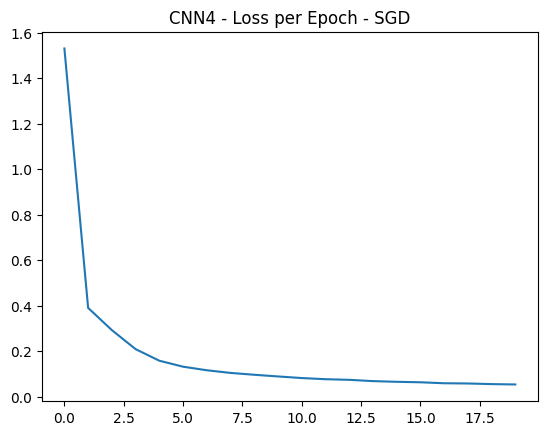

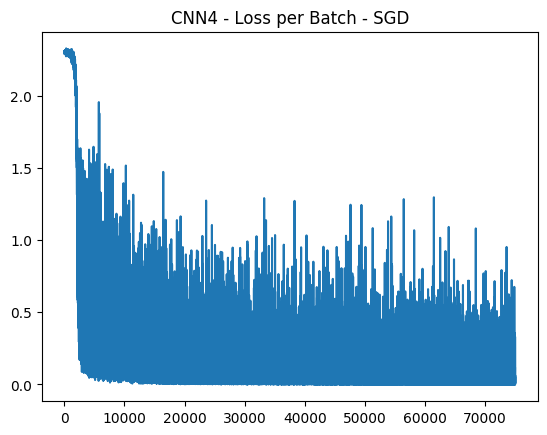

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

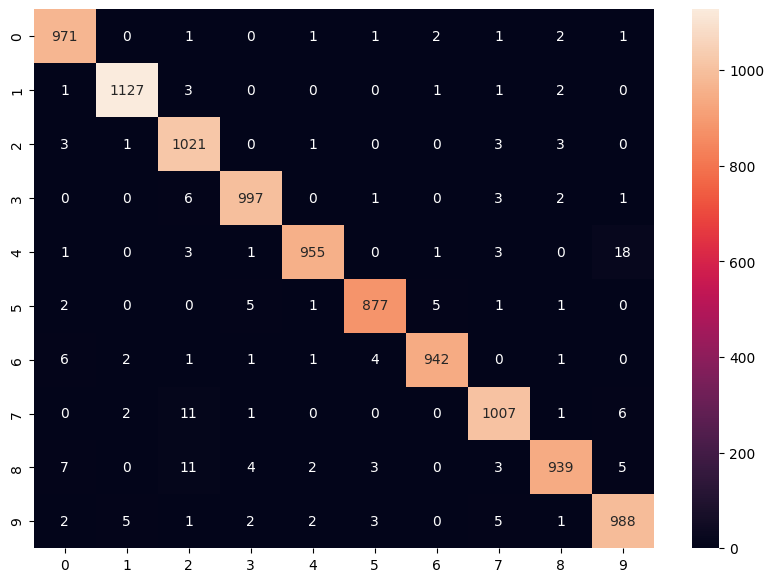

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9824

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9823273896170137

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9825409470349825

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.982205016032464

#### **Nestrov Momemtum SGD - MLP 4 Layer**

In [ ]:
input_size = 28 * 28 # MNIST pixel dimension
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerPerceptron4(input_size, num_classes) 
model.to(device)

MultiLayerPerceptron4(
  (MLP): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
nestrov_momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = nestrov_momentum, nesterov=True)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
mlp4_batch_loss = []
mlp4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        mlp4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    mlp4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 1.4379980083624522
Epoch: 2 Loss: 0.32818175831362606
Epoch: 3 Loss: 0.18871879472496608
Epoch: 4 Loss: 0.13141442893488953
Epoch: 5 Loss: 0.10129363141624878
Epoch: 6 Loss: 0.07974368968934287
Epoch: 7 Loss: 0.06503757541380667
Epoch: 8 Loss: 0.05307038990968528
Epoch: 9 Loss: 0.04416000029218461
Epoch: 10 Loss: 0.03584075202553941
Epoch: 11 Loss: 0.0299352300123622
Epoch: 12 Loss: 0.023297859102042275
Epoch: 13 Loss: 0.01903265944537464
Epoch: 14 Loss: 0.014959884192276755
Epoch: 15 Loss: 0.011537275455500942
Epoch: 16 Loss: 0.009048821171518163
Epoch: 17 Loss: 0.0066423627523000805
Epoch: 18 Loss: 0.004588845165522919
Epoch: 19 Loss: 0.0036745954276288404
Epoch: 20 Loss: 0.0017652962278616694
Training Time: 0:03:00.062638


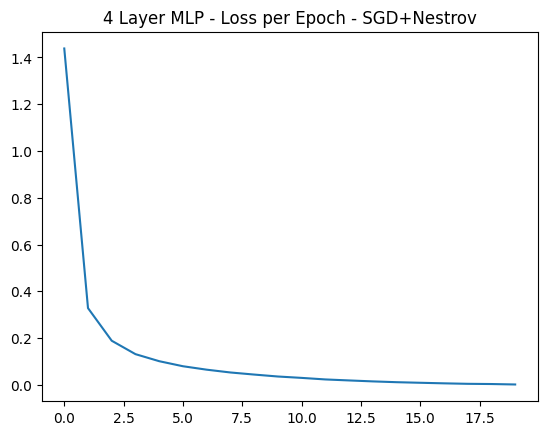

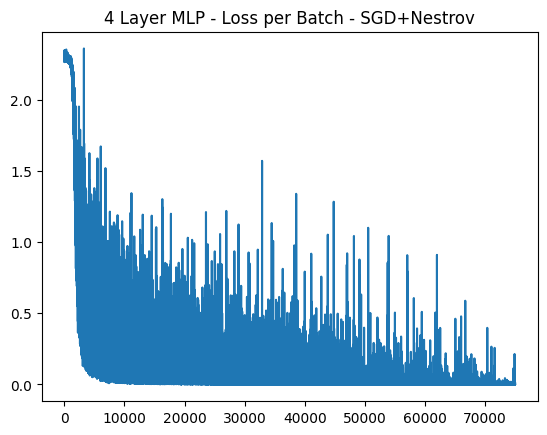

In [ ]:
plt.plot(mlp4_epoch_loss)
plt.title("4 Layer MLP - Loss per Epoch")
plt.show()
plt.plot(mlp4_batch_loss)
plt.title("4 Layer MLP - Loss per Batch")
plt.show()

Let's evaluate the performance of the model against the test dataset

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

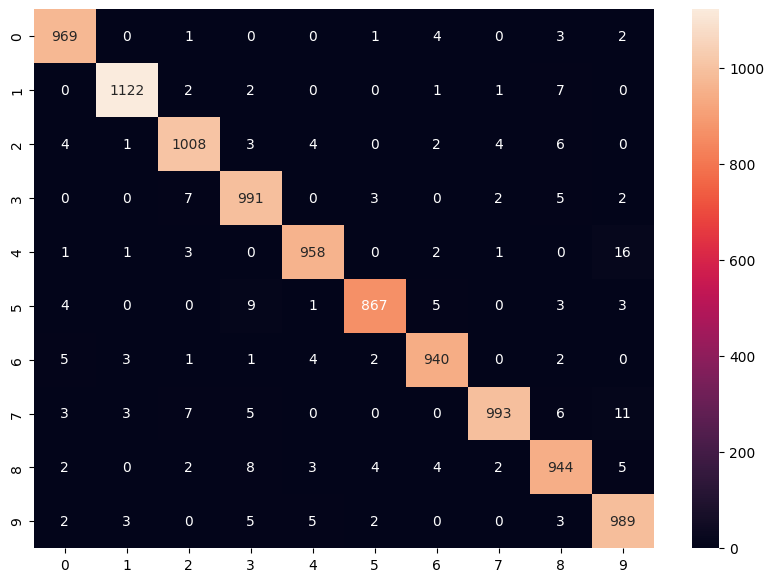

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9781

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9779791994532765

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9781008622386068

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9779328982643488

#### **Nestrov Momemtum SGD - RBF 2 Layer(100 + 50)**

In [ ]:
number_of_rbf1 = 100
num_layer1_linear_nodes = 75
number_of_rbf2 = 50
num_classes = 10 # we have 10 classes in MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)
x = torch.from_numpy(xtrain.T).to(device).contiguous()
y = torch.from_numpy(ytrain.T).to(device).contiguous()

In [ ]:
kmeans = KMeans(n_clusters=number_of_rbf1, distance="euclidean")
kmeans.fit(x)
clusters1 = kmeans.centroids.T.cpu().numpy()
print(clusters1.shape)

(100, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet2Layer(clusters1, num_layer1_linear_nodes, number_of_rbf2, num_classes, device)
model.to(device)

RBFnet2Layer(
  (linear1): Linear(in_features=100, out_features=75, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.001
nestrov_momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = nestrov_momentum, nesterov=True)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf_batch_loss = []
rbf_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 2.300923887457119
Epoch: 2 Loss: 2.2942370177271294
Epoch: 3 Loss: 2.281494140117181
Epoch: 4 Loss: 2.2514908300572523
Epoch: 5 Loss: 2.1852156400163865
Epoch: 6 Loss: 2.0758645060289815
Epoch: 7 Loss: 1.9683139183501126
Epoch: 8 Loss: 1.8822549353036908
Epoch: 9 Loss: 1.803414500929222
Epoch: 10 Loss: 1.7199496063928332
Epoch: 11 Loss: 1.6274986940862108
Epoch: 12 Loss: 1.5299266250355241
Epoch: 13 Loss: 1.4356687672334238
Epoch: 14 Loss: 1.351034202677529
Epoch: 15 Loss: 1.2767342613734232
Epoch: 16 Loss: 1.2109761645970423
Epoch: 17 Loss: 1.1522788013506973
Epoch: 18 Loss: 1.0988548029040268
Epoch: 19 Loss: 1.0502912699997973
Epoch: 20 Loss: 1.0062001860657293
Training Time: 0:02:56.367853


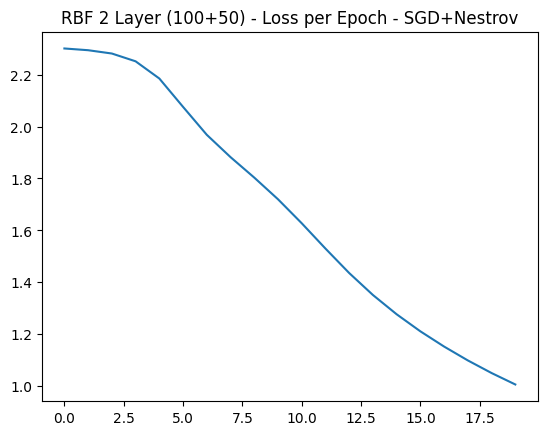

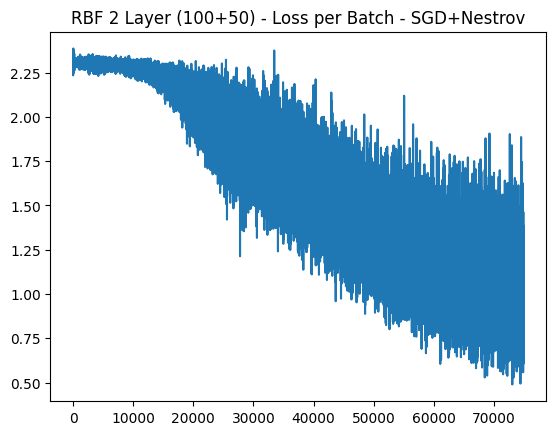

In [ ]:
plt.plot(rbf_epoch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Epoch")
plt.show()
plt.plot(rbf_batch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

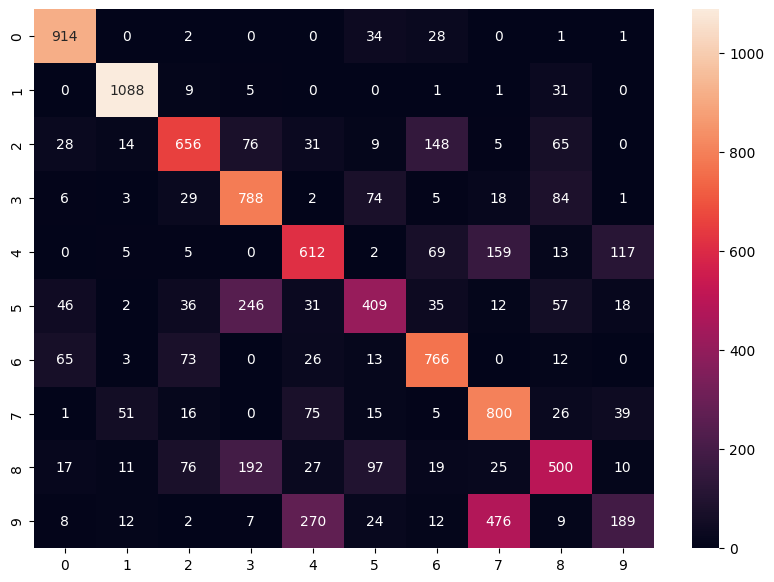

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.6722

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.6514203722578097

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.6626148471822242

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.6667292181336626

#### **Nestrov Momemtum SGD - CNN 4 Layer**

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4(input_channel_size, num_classes)
model.to(device)

CNN4(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
nestrov_momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = nestrov_momentum, nesterov=True)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.33704452872114876
Epoch: 2 Loss: 0.08731446082435237
Epoch: 3 Loss: 0.06425706289457933
Epoch: 4 Loss: 0.050138446440427406
Epoch: 5 Loss: 0.04326601903708264
Epoch: 6 Loss: 0.036841343037098705
Epoch: 7 Loss: 0.03229034112397251
Epoch: 8 Loss: 0.027771587713348225
Epoch: 9 Loss: 0.025423364600721348
Epoch: 10 Loss: 0.02199780184776585
Epoch: 11 Loss: 0.020843205673831834
Epoch: 12 Loss: 0.0179399963705604
Epoch: 13 Loss: 0.016307355218751762
Epoch: 14 Loss: 0.015572921875504167
Epoch: 15 Loss: 0.014130813137501445
Epoch: 16 Loss: 0.012008399775781648
Epoch: 17 Loss: 0.010653261567170344
Epoch: 18 Loss: 0.011428688955219195
Epoch: 19 Loss: 0.009407385353695234
Epoch: 20 Loss: 0.008556511505158576
Training Time: 0:03:48.677339


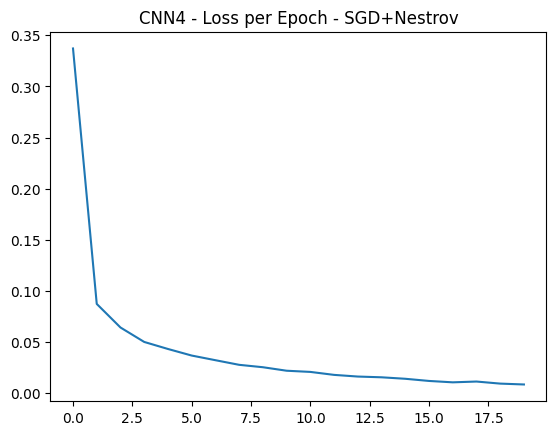

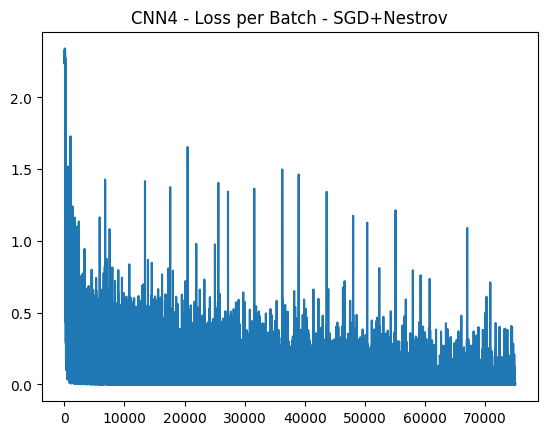

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

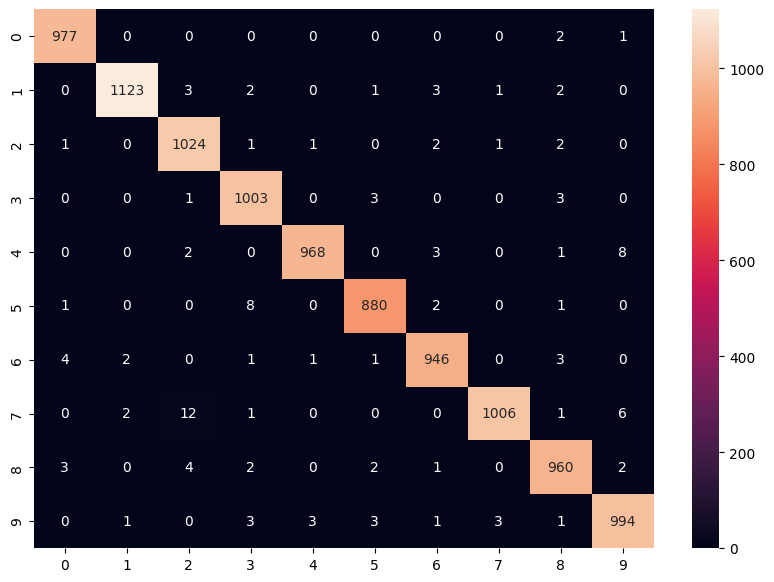

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9881

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9880579488246175

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9880722434434028

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9880807128250421

#### **RMSProp - MLP 4 Layer**

In [ ]:
input_size = 28 * 28 # MNIST pixel dimension
num_classes = 10 # we have 10 classes in MNIST
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerPerceptron4(input_size, num_classes) 
model.to(device)

MultiLayerPerceptron4(
  (MLP): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
mlp4_batch_loss = []
mlp4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        mlp4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    mlp4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.23508205593331563
Epoch: 2 Loss: 0.10785843234326457
Epoch: 3 Loss: 0.07988033480228163
Epoch: 4 Loss: 0.06904580495036683
Epoch: 5 Loss: 0.059981919124081774
Epoch: 6 Loss: 0.0572791910918804
Epoch: 7 Loss: 0.04859453977311353
Epoch: 8 Loss: 0.048055051395414494
Epoch: 9 Loss: 0.04588791148742728
Epoch: 10 Loss: 0.04872691521734709
Epoch: 11 Loss: 0.04406308369204942
Epoch: 12 Loss: 0.042718439069645446
Epoch: 13 Loss: 0.04473466069864445
Epoch: 14 Loss: 0.04522706631317442
Epoch: 15 Loss: 0.040040596637984836
Epoch: 16 Loss: 0.04043008324764163
Epoch: 17 Loss: 0.04661367017121599
Epoch: 18 Loss: 0.042138447132941285
Epoch: 19 Loss: 0.043552303323457255
Epoch: 20 Loss: 0.04670993862016054
Training Time: 0:03:05.167465


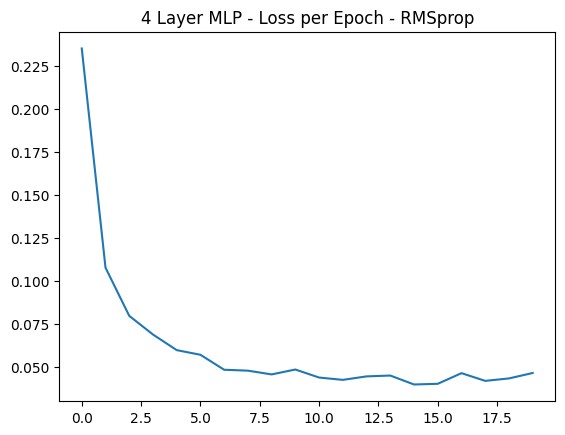

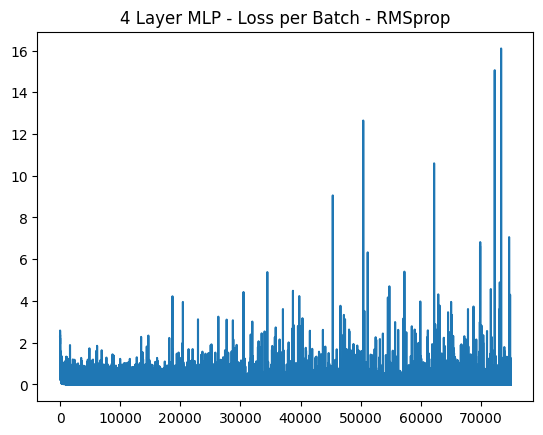

In [ ]:
plt.plot(mlp4_epoch_loss)
plt.title("4 Layer MLP - Loss per Epoch")
plt.show()
plt.plot(mlp4_batch_loss)
plt.title("4 Layer MLP - Loss per Batch")
plt.show()

Let's evaluate the performance of the model against the test dataset

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

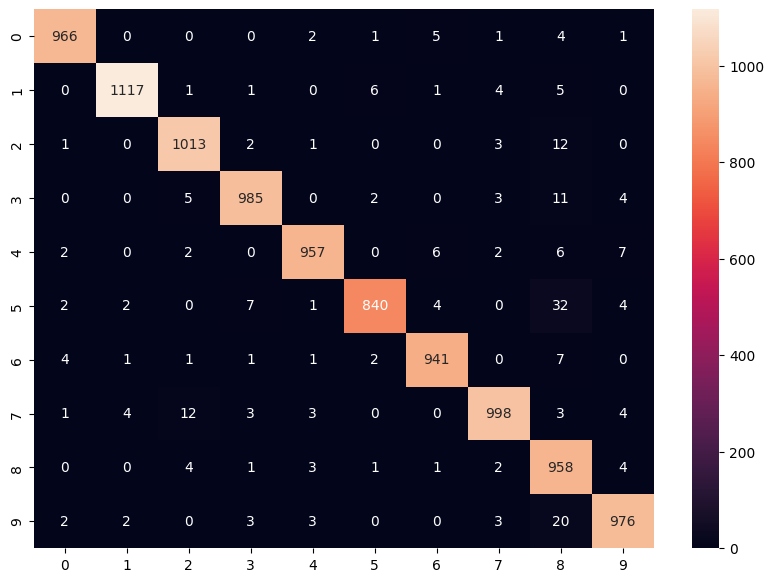

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9751

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9748808200999592

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9755223796964863

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9746876778346719

#### **RMSProp - RBF 2 Layer (100+50)**

In [ ]:
number_of_rbf1 = 100
num_layer1_linear_nodes = 75
number_of_rbf2 = 50
num_classes = 10 # we have 10 classes in MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)
x = torch.from_numpy(xtrain.T).to(device).contiguous()
y = torch.from_numpy(ytrain.T).to(device).contiguous()

In [ ]:
kmeans = KMeans(n_clusters=number_of_rbf1, distance="euclidean")
kmeans.fit(x)
clusters1 = kmeans.centroids.T.cpu().numpy()
print(clusters1.shape)

(100, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet2Layer(clusters1, num_layer1_linear_nodes, number_of_rbf2, num_classes, device)
model.to(device)

RBFnet2Layer(
  (linear1): Linear(in_features=100, out_features=75, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf_batch_loss = []
rbf_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 1.3035040231142119
Epoch: 2 Loss: 0.6646068034488755
Epoch: 3 Loss: 0.4908802715872582
Epoch: 4 Loss: 0.4107353778724372
Epoch: 5 Loss: 0.37299670509187755
Epoch: 6 Loss: 0.34986062815902946
Epoch: 7 Loss: 0.333245332925101
Epoch: 8 Loss: 0.3202580881731001
Epoch: 9 Loss: 0.30965614789276025
Epoch: 10 Loss: 0.30108727656503104
Epoch: 11 Loss: 0.2939521833360113
Epoch: 12 Loss: 0.28843929102233634
Epoch: 13 Loss: 0.281848064131249
Epoch: 14 Loss: 0.2767826124665106
Epoch: 15 Loss: 0.27246315570036134
Epoch: 16 Loss: 0.2679114749254281
Epoch: 17 Loss: 0.263955969344684
Epoch: 18 Loss: 0.2604891111121642
Epoch: 19 Loss: 0.2562787777002275
Epoch: 20 Loss: 0.25353101540383116
Training Time: 0:03:01.479396


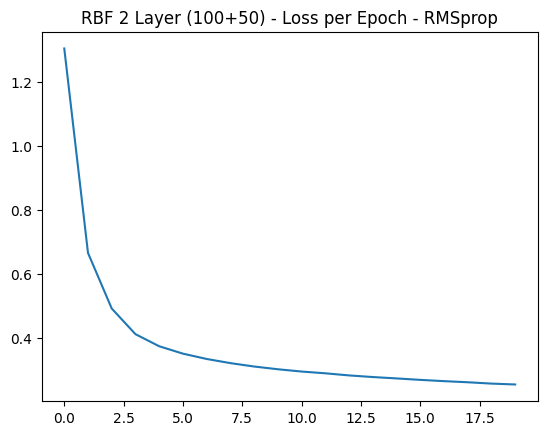

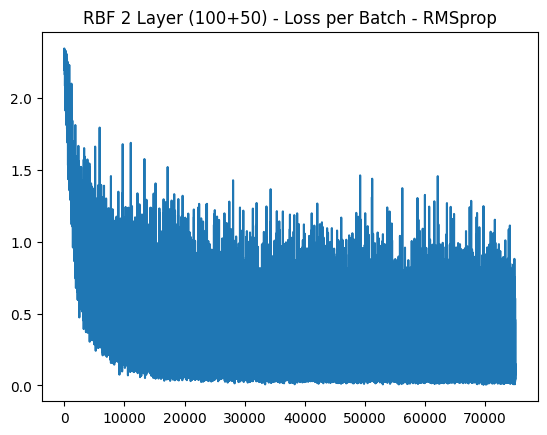

In [ ]:
plt.plot(rbf_epoch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Epoch")
plt.show()
plt.plot(rbf_batch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

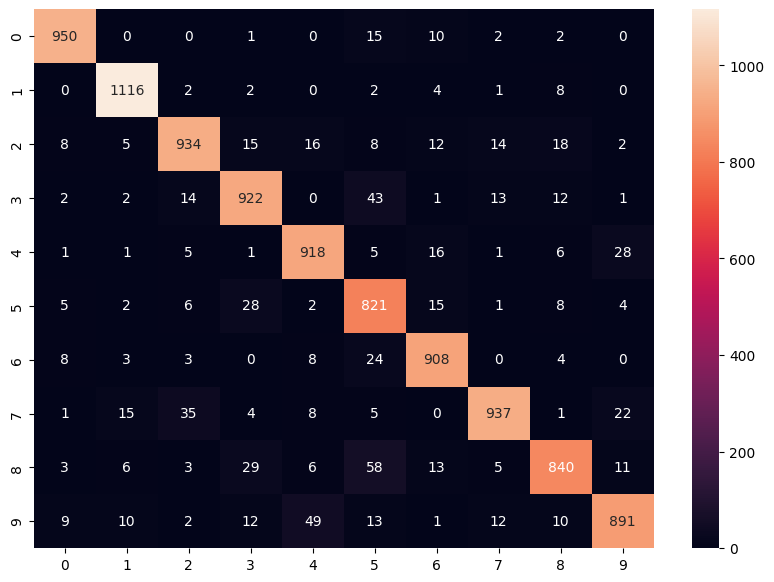

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9237

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9225958251862393

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.92317252214294

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9230550242786546

#### **RMSProp - CNN 4 Layer**

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4(input_channel_size, num_classes)
model.to(device)

CNN4(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.1408813060230265
Epoch: 2 Loss: 0.04499686000540217
Epoch: 3 Loss: 0.03351679753777995
Epoch: 4 Loss: 0.026506419005094116
Epoch: 5 Loss: 0.022190444802984106
Epoch: 6 Loss: 0.01856082114013003
Epoch: 7 Loss: 0.016633869418361567
Epoch: 8 Loss: 0.013493608443380123
Epoch: 9 Loss: 0.013213284254532241
Epoch: 10 Loss: 0.011158534422216483
Epoch: 11 Loss: 0.009668176255090647
Epoch: 12 Loss: 0.009769148603097699
Epoch: 13 Loss: 0.009473529541908431
Epoch: 14 Loss: 0.007860853671357228
Epoch: 15 Loss: 0.008710020667425718
Epoch: 16 Loss: 0.007802204836076499
Epoch: 17 Loss: 0.006558807122483892
Epoch: 18 Loss: 0.007758150816449827
Epoch: 19 Loss: 0.008356714145882491
Epoch: 20 Loss: 0.006808510088750961
Training Time: 0:04:01.808749


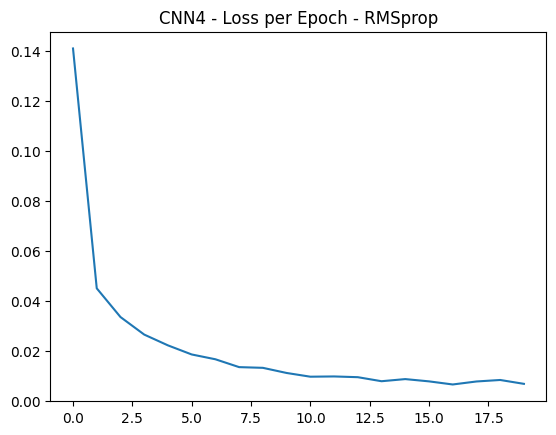

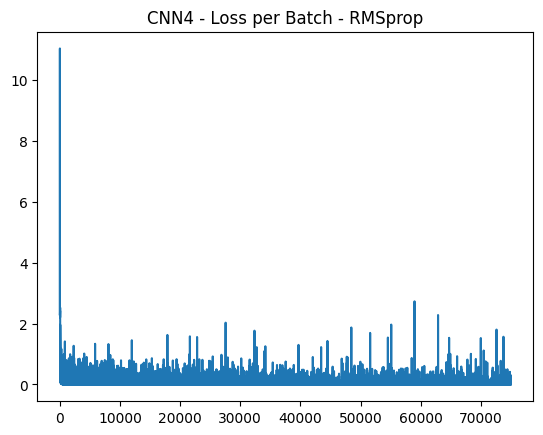

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

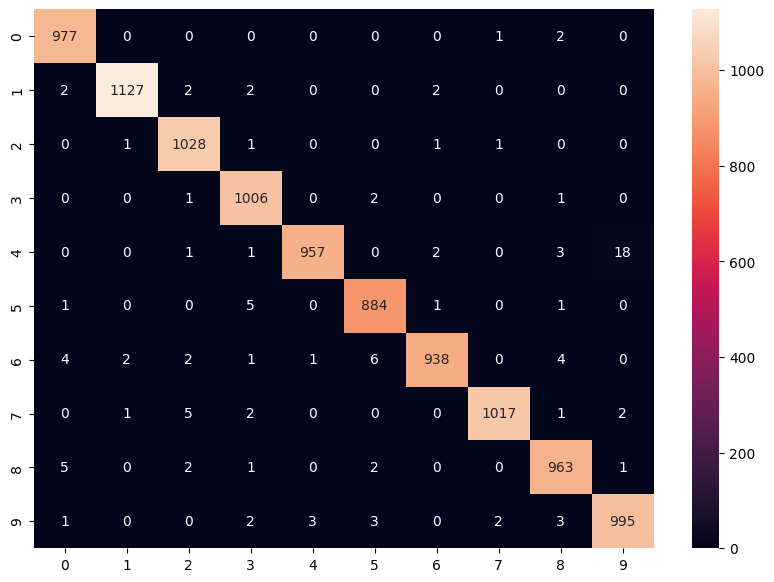

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9892

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.989076896182057

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9891217063318252

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9890881119781245

## Experiment 3: Exploring the parameters of CNN. Kernel Size? Channels? Strides? Do they affect the performance in any significant way?

#### **CNN2 - Kernel Size 5**

In [ ]:
class CNN2K5(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2K5, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 4, 
                     kernel_size = 5, stride = 1, padding = 2), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 4, out_channels = 8, 
                     kernel_size = 5, stride = 1, padding = 2), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(8*(14*14), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2K5(input_channel_size, num_classes)
model.to(device)

CNN2K5(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.21439453990592933
Epoch: 2 Loss: 0.08581128712435214
Epoch: 3 Loss: 0.06492807589124326
Epoch: 4 Loss: 0.05386117580869468
Epoch: 5 Loss: 0.04623858170327051
Epoch: 6 Loss: 0.042664260227405854
Epoch: 7 Loss: 0.03740377858359425
Epoch: 8 Loss: 0.03371237668133672
Epoch: 9 Loss: 0.03107930166336864
Epoch: 10 Loss: 0.030454468142384453
Epoch: 11 Loss: 0.02801461988982352
Epoch: 12 Loss: 0.026026414104237606
Epoch: 13 Loss: 0.026001577533314654
Epoch: 14 Loss: 0.02395105916627096
Epoch: 15 Loss: 0.02291953937008014
Epoch: 16 Loss: 0.021557852035536052
Epoch: 17 Loss: 0.020212520737394758
Epoch: 18 Loss: 0.020257599386610484
Epoch: 19 Loss: 0.0203473204474887
Epoch: 20 Loss: 0.019035538292656085
Training Time: 0:03:23.234756


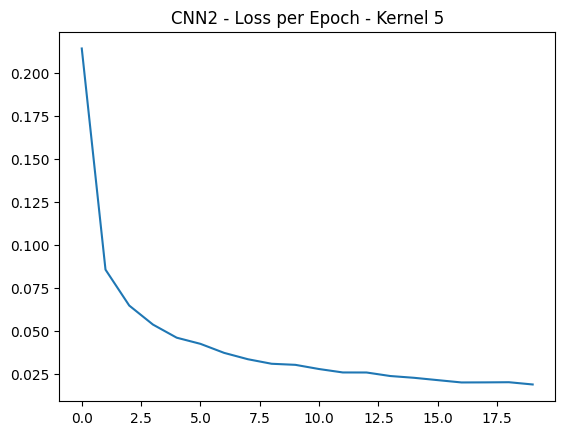

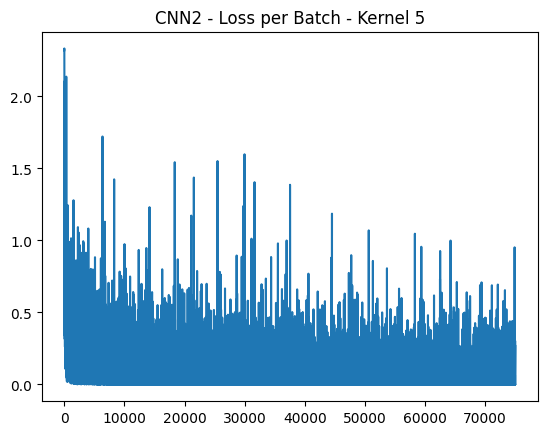

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

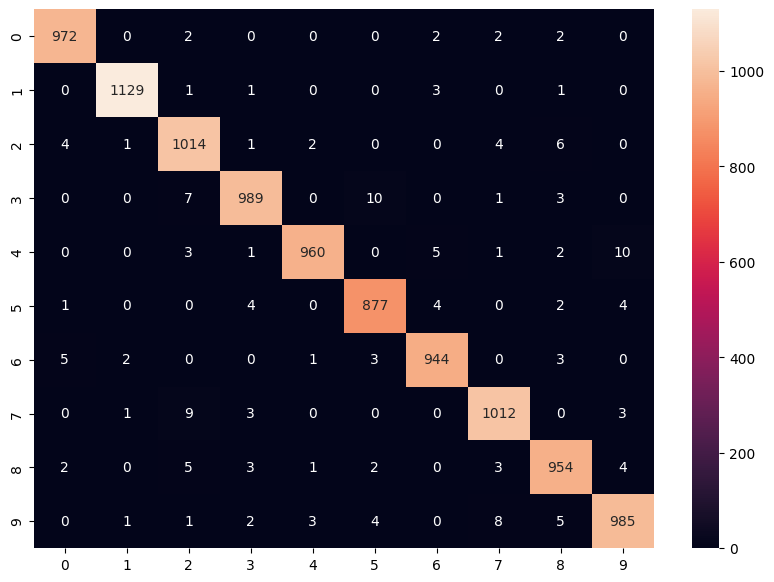

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9836

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9834533613755048

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9834682709003282

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9834599260651127

#### **CNN2 - Kernel Size 7**

In [ ]:
class CNN2K7(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2K7, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 4, 
                     kernel_size = 7, stride = 1, padding = 3), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            # Convolutional Layer 2
            nn.Conv2d( in_channels = 4, out_channels = 8, 
                     kernel_size = 7, stride = 1, padding = 3), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(8*(14*14), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2K7(input_channel_size, num_classes)
model.to(device)

CNN2K7(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.18044772016031202
Epoch: 2 Loss: 0.07240169301093168
Epoch: 3 Loss: 0.05502813530129303
Epoch: 4 Loss: 0.04334917809283094
Epoch: 5 Loss: 0.03717785976704957
Epoch: 6 Loss: 0.03290990641421655
Epoch: 7 Loss: 0.028656405374043365
Epoch: 8 Loss: 0.026213760637087215
Epoch: 9 Loss: 0.023792066586733017
Epoch: 10 Loss: 0.022909213932017974
Epoch: 11 Loss: 0.020268012152517334
Epoch: 12 Loss: 0.02060384909883954
Epoch: 13 Loss: 0.019733024472216486
Epoch: 14 Loss: 0.01820836136707404
Epoch: 15 Loss: 0.01694742739447239
Epoch: 16 Loss: 0.016869265502958756
Epoch: 17 Loss: 0.015476164577558297
Epoch: 18 Loss: 0.015506580131735859
Epoch: 19 Loss: 0.015270551559022938
Epoch: 20 Loss: 0.014598470982929454
Training Time: 0:03:33.986338


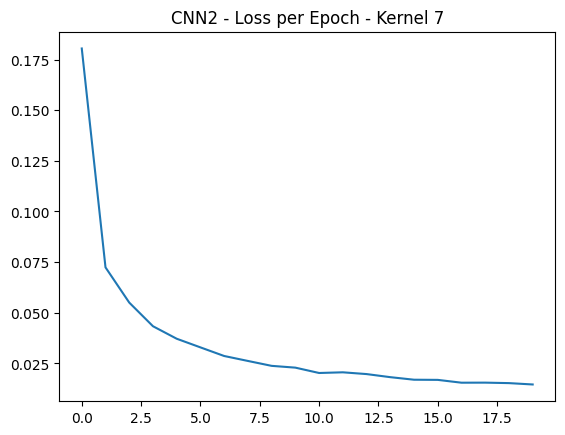

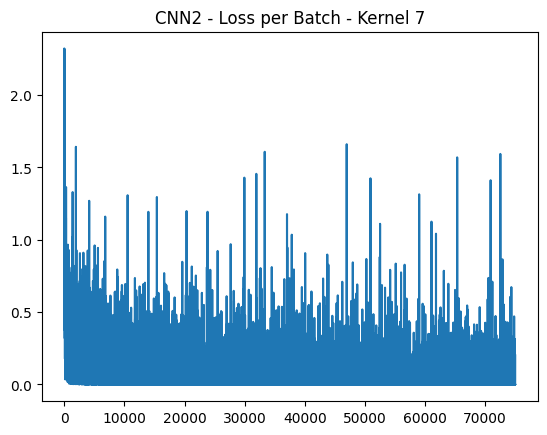

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

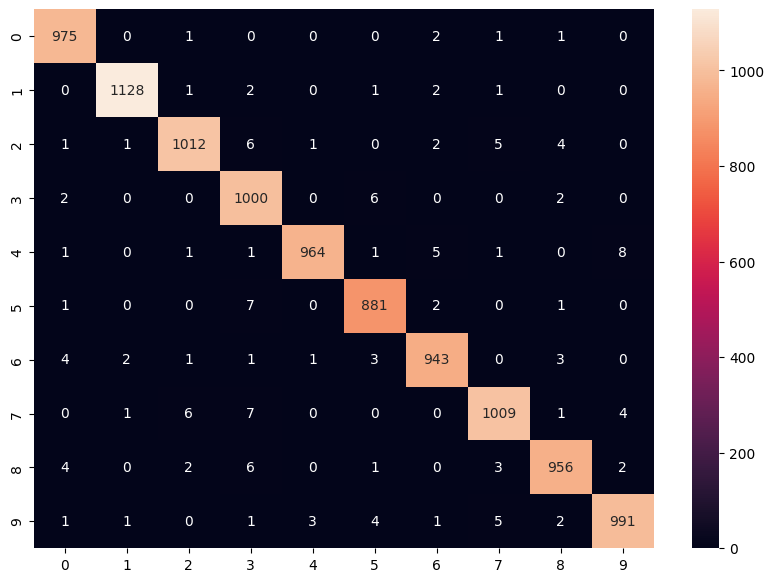

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9859

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9857984466316575

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9858045242138258

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9858327897654828

#### **CNN2 - Stride 2**

In [ ]:
class CNN2S2(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2S2, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 4, 
                     kernel_size = 3, stride = 2, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 4, out_channels = 8, 
                     kernel_size = 3, stride = 2, padding = 1), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(8*(4*4), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2S2(input_channel_size, num_classes)
model.to(device)

CNN2S2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.598467530416449
Epoch: 2 Loss: 0.309623500178506
Epoch: 3 Loss: 0.2491606599467496
Epoch: 4 Loss: 0.22537209162252644
Epoch: 5 Loss: 0.2119126934468746
Epoch: 6 Loss: 0.204569303715912
Epoch: 7 Loss: 0.20094664615082244
Epoch: 8 Loss: 0.19181090466044842
Epoch: 9 Loss: 0.18887423401549458
Epoch: 10 Loss: 0.1850219846923525
Epoch: 11 Loss: 0.180271179140235
Epoch: 12 Loss: 0.17866166423801333
Epoch: 13 Loss: 0.17454352032765746
Epoch: 14 Loss: 0.17244212134263168
Epoch: 15 Loss: 0.168518761979416
Epoch: 16 Loss: 0.1675797019091745
Epoch: 17 Loss: 0.1676208740211092
Epoch: 18 Loss: 0.16449445005307595
Epoch: 19 Loss: 0.15662603184624266
Epoch: 20 Loss: 0.159001212049524
Training Time: 0:03:19.072553


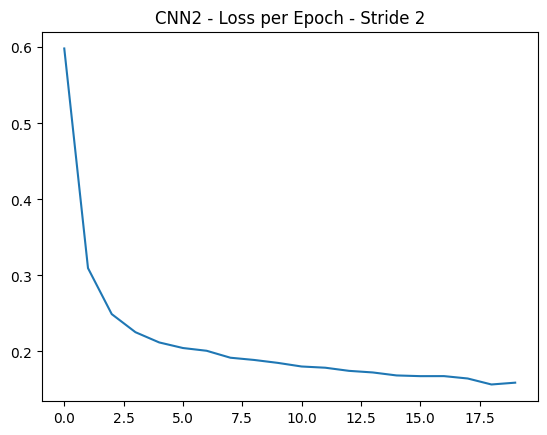

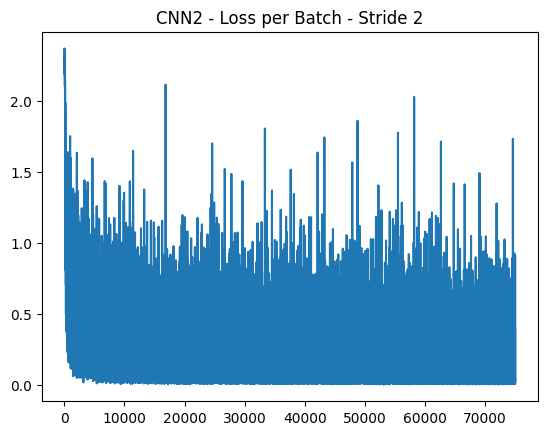

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

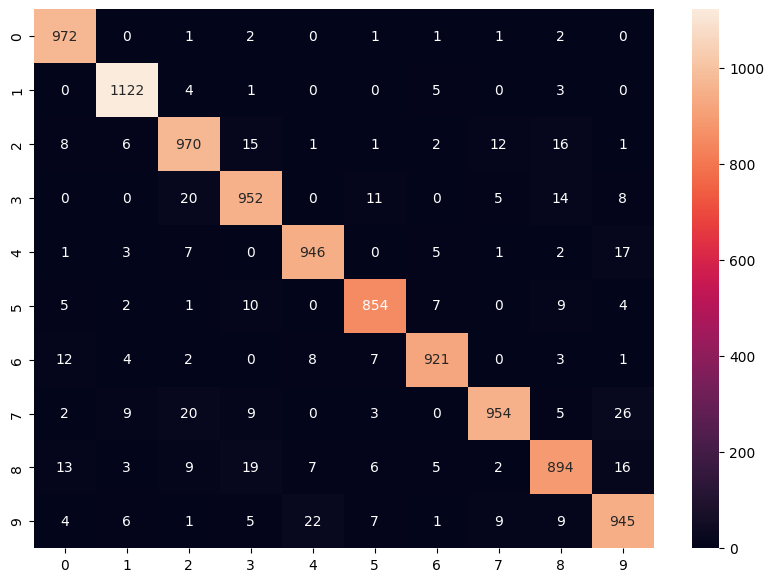

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.953

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9527538180245205

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9529611469257784

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9527447726976875

#### **CNN2 - Stride 3**

In [ ]:
class CNN2S3(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2S3, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 4, 
                     kernel_size = 3, stride = 3, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 4, out_channels = 8, 
                     kernel_size = 3, stride = 3, padding = 1), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(8*(2*2), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2S3(input_channel_size, num_classes)
model.to(device)

CNN2S3(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.9803997437477112
Epoch: 2 Loss: 0.6579973411440849
Epoch: 3 Loss: 0.5584639194011688
Epoch: 4 Loss: 0.5116025255729755
Epoch: 5 Loss: 0.4830511086603006
Epoch: 6 Loss: 0.46667765455245974
Epoch: 7 Loss: 0.45517417607307437
Epoch: 8 Loss: 0.4488824175129334
Epoch: 9 Loss: 0.4418429799710711
Epoch: 10 Loss: 0.44010238439291716
Epoch: 11 Loss: 0.43758934226135415
Epoch: 12 Loss: 0.43162085459878047
Epoch: 13 Loss: 0.4288960008646051
Epoch: 14 Loss: 0.42764259603818255
Epoch: 15 Loss: 0.42659250725507736
Epoch: 16 Loss: 0.42276614771435655
Epoch: 17 Loss: 0.4222884082039197
Epoch: 18 Loss: 0.42010295651853086
Epoch: 19 Loss: 0.41928688129583996
Epoch: 20 Loss: 0.4176085524107019
Training Time: 0:03:19.718965


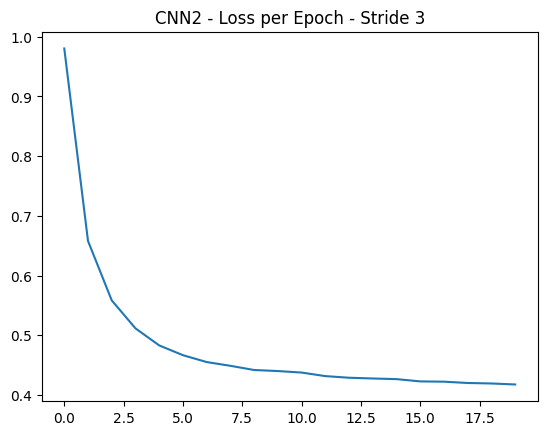

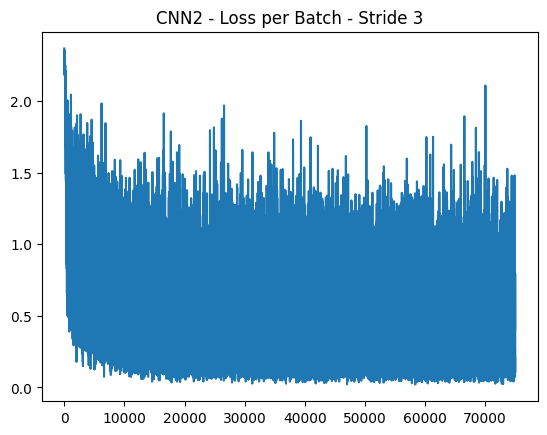

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

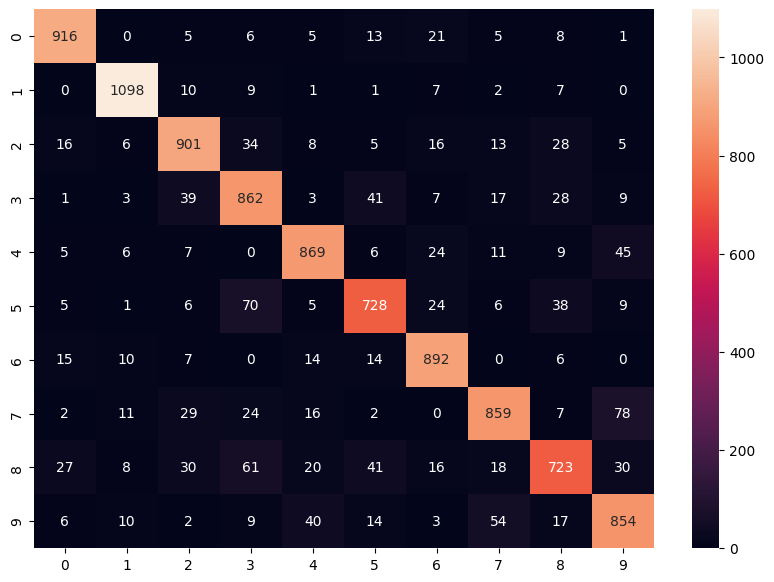

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.8702

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.8681573398943687

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.8687408339316663

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.8685086271614001

#### **CNN2 - Channel Progression - [1,8,16]**

In [ ]:
class CNN2C8(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2C8, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 8, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 8, out_channels = 16, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(16*(14*14), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2C8(input_channel_size, num_classes)
model.to(device)

CNN2C8(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=3136, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.18222596059699234
Epoch: 2 Loss: 0.06948644926536363
Epoch: 3 Loss: 0.05105110820965007
Epoch: 4 Loss: 0.0403798476140723
Epoch: 5 Loss: 0.03411631065579204
Epoch: 6 Loss: 0.028357603852285442
Epoch: 7 Loss: 0.025718524136789347
Epoch: 8 Loss: 0.021572771774827137
Epoch: 9 Loss: 0.0190324814269549
Epoch: 10 Loss: 0.017952586328483646
Epoch: 11 Loss: 0.01511443631164725
Epoch: 12 Loss: 0.015474858574937555
Epoch: 13 Loss: 0.012450564827776001
Epoch: 14 Loss: 0.011611421658246114
Epoch: 15 Loss: 0.012271038188213014
Epoch: 16 Loss: 0.011499146420622938
Epoch: 17 Loss: 0.009372467644731947
Epoch: 18 Loss: 0.009693092512962291
Epoch: 19 Loss: 0.01013593680959135
Epoch: 20 Loss: 0.009723769378392502
Training Time: 0:03:24.765128


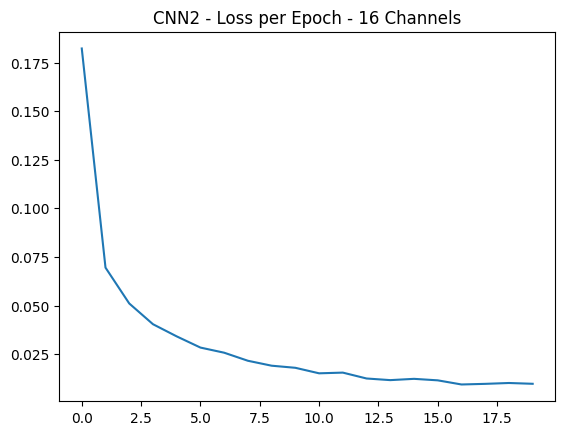

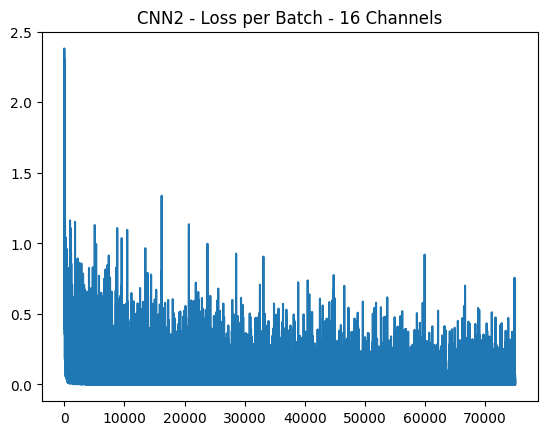

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

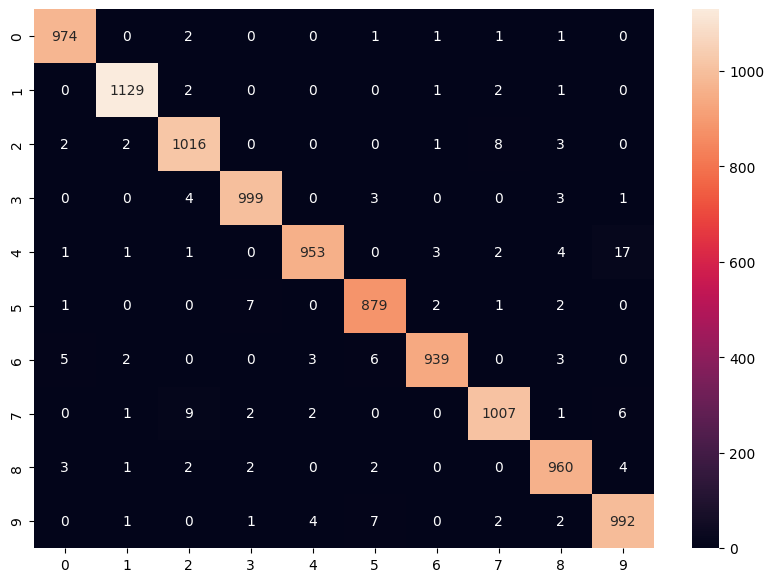

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9848

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.984667750705723

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9847158313724794

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9846607600770264

#### **CNN2 - Channel Progression - [1,16,32]**

In [ ]:
class CNN2C16(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN2C16, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 16, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 16, out_channels = 32, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True), 
        )
        
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(32*(14*14), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN2C16(input_channel_size, num_classes)
model.to(device)

CNN2C16(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn2_batch_loss = []
cnn2_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.shape)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn2_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn2_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.14931446413330268
Epoch: 2 Loss: 0.05312318845653208
Epoch: 3 Loss: 0.03777622101632345
Epoch: 4 Loss: 0.029048360313895683
Epoch: 5 Loss: 0.02166968455263365
Epoch: 6 Loss: 0.018388893156046138
Epoch: 7 Loss: 0.014826202624753933
Epoch: 8 Loss: 0.01255712228444291
Epoch: 9 Loss: 0.011307609296868953
Epoch: 10 Loss: 0.009612386875818484
Epoch: 11 Loss: 0.008624201190377013
Epoch: 12 Loss: 0.007622785056115534
Epoch: 13 Loss: 0.007468634658013923
Epoch: 14 Loss: 0.005999160006591266
Epoch: 15 Loss: 0.005865397114362832
Epoch: 16 Loss: 0.005827769769714785
Epoch: 17 Loss: 0.005557838220234101
Epoch: 18 Loss: 0.004825551290584305
Epoch: 19 Loss: 0.004301142748955044
Epoch: 20 Loss: 0.004677262971901285
Training Time: 0:03:27.850305


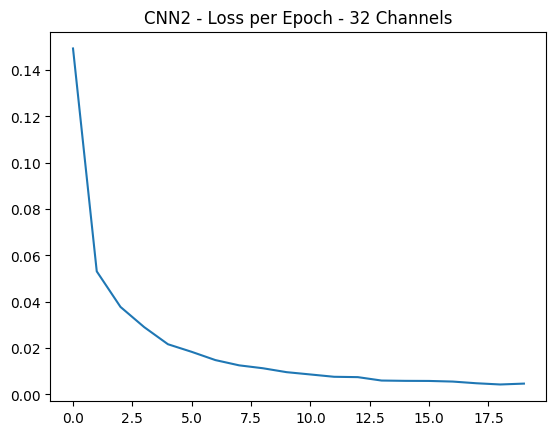

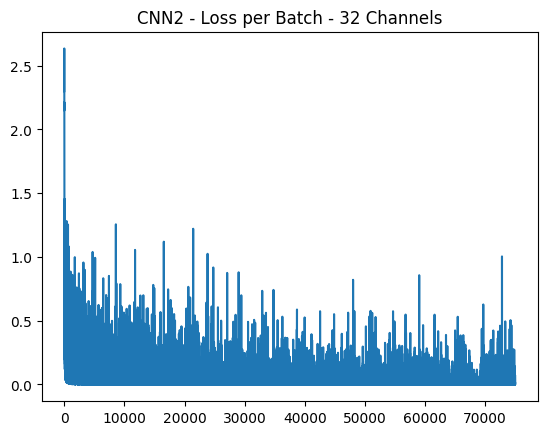

In [ ]:
plt.plot(cnn2_epoch_loss)
plt.title("CNN2 - Loss per Epoch")
plt.show()
plt.plot(cnn2_batch_loss)
plt.title("CNN2 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((10,10), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

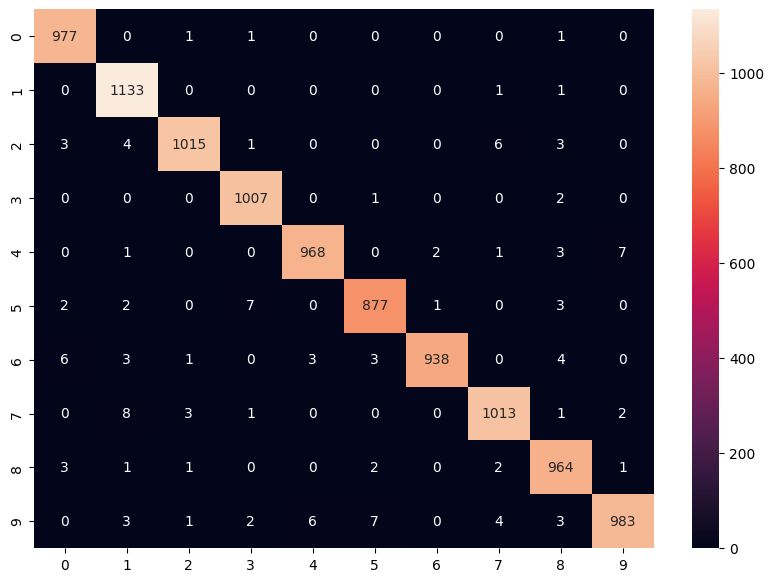

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9875

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9874333920451507

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9876170729845217

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9873157439005776

## Experiment 4: Let's take the worst model and best model and train only on the most confused pair of digits based on confusion matrix and see how it performs

### Best Model - CNN4 - Binary Implementation

In [ ]:
class CNN4Binary(nn.Module):   
    def __init__(self, size):
        super(CNN4Binary, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 8, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 8, out_channels = 16, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            
            # Max Pool and Dropout
            nn.MaxPool2d(2), 
            nn.Dropout(0.1),

            # Convolutional Layer 3
            nn.Conv2d( in_channels = 16, out_channels = 32, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.Conv2d( in_channels = 32, out_channels = 64, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
        )
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(64*(14*14), 1), 
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.sigmoid(self.linear(x))

#### **5 vs 3 Digit Classification**



In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

idx1 = train.targets==5
idx2 = train.targets==3
idx = torch.logical_or(idx1, idx2)

print("Binary Encode the two digits")

train_y = train.targets[idx]
print(train_y)
encoder = LabelEncoder()
encoder.fit(train_y)

train_y = encoder.transform(train_y)
train.targets = torch.from_numpy(train_y)
train.data = train.data[idx]

idx1 = test.targets==5
idx2 = test.targets==3
idx = torch.logical_or(idx1, idx2)

test_y = test.targets[idx]
print(test_y)
test_y = encoder.transform(test_y)
test.targets = torch.from_numpy(test_y)
test.data = test.data[idx]

print(train.targets)
print(test.targets)

Binary Encode the two digits
tensor([5, 3, 3,  ..., 5, 3, 5])
tensor([5, 5, 3,  ..., 5, 3, 5])
tensor([1, 0, 0,  ..., 1, 0, 1])
tensor([1, 1, 0,  ..., 1, 0, 1])


In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4Binary(input_channel_size)
model.to(device)

CNN4Binary(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss() # Binary Cross Entropy

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        labels = labels.reshape(batch_size, -1).to(dtype=torch.float)
        # print(labels)

        # lets predict (forward pass)
        prediction = model(samples)
        # print(prediction)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.07771082290763996
Epoch: 2 Loss: 0.020494092351999123
Epoch: 3 Loss: 0.013687256025135066
Epoch: 4 Loss: 0.011033050868023447
Epoch: 5 Loss: 0.00937226932443025
Epoch: 6 Loss: 0.0058967024543207895
Epoch: 7 Loss: 0.007730699514506784
Epoch: 8 Loss: 0.006234081283561994
Epoch: 9 Loss: 0.005558778028927656
Epoch: 10 Loss: 0.0036214317217246952
Epoch: 11 Loss: 0.0066944378973109574
Epoch: 12 Loss: 0.003333530456258321
Epoch: 13 Loss: 0.005119018469629545
Epoch: 14 Loss: 0.003288515024595233
Epoch: 15 Loss: 0.0007783159752873269
Epoch: 16 Loss: 0.006001982663087495
Epoch: 17 Loss: 0.0037832438982713574
Epoch: 18 Loss: 0.0003995402603841559
Epoch: 19 Loss: 0.0015715960181569026
Epoch: 20 Loss: 0.0047452446384659
Training Time: 0:00:51.937951


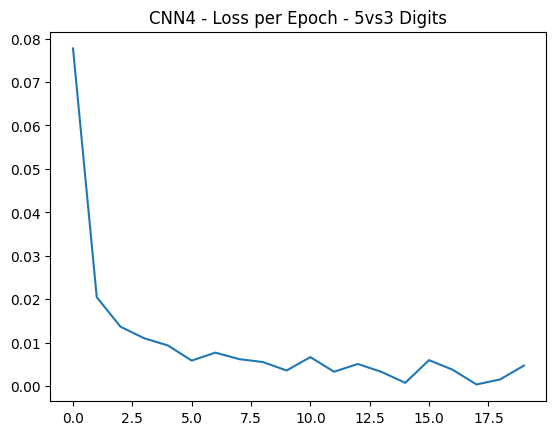

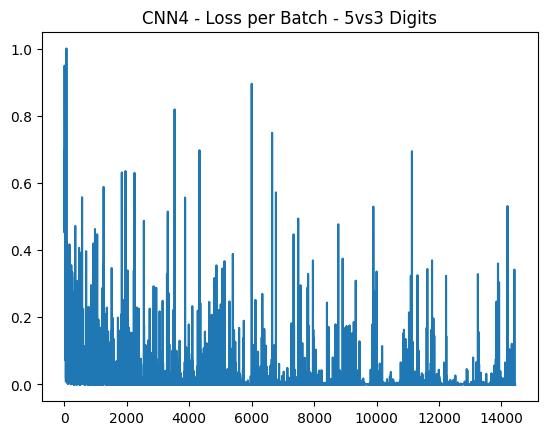

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((2,2), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params
    label = int(label.item())
    # print(label)
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    prediction = int(prediction.round().cpu().item())
    # print(prediction)
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

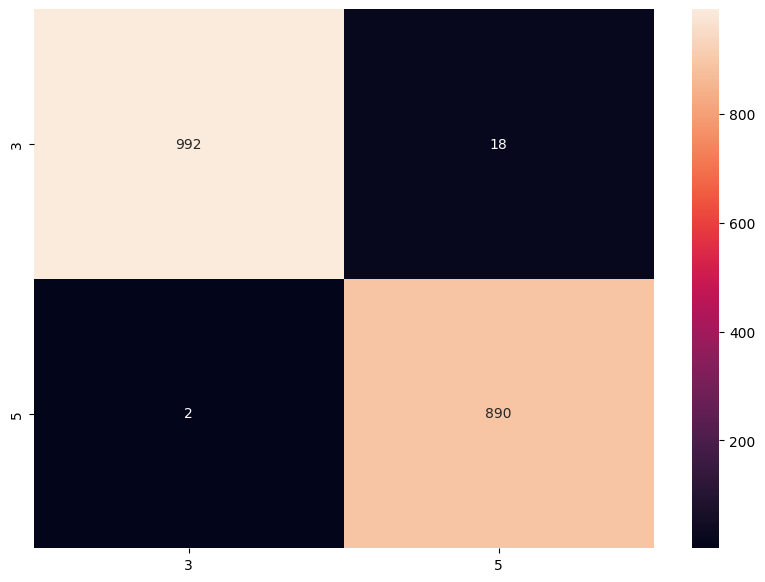

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "35"],
                  columns = [i for i in "35"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9894847528916929

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9894544244843646

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9890820695095683

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9899680326777072

#### **4 vs 9 Digit Classification**

In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

idx1 = train.targets==4
idx2 = train.targets==9
idx = torch.logical_or(idx1, idx2)

print("Binary Encode the two digits")

train_y = train.targets[idx]
print(train_y)
encoder = LabelEncoder()
encoder.fit(train_y)

train_y = encoder.transform(train_y)
train.targets = torch.from_numpy(train_y)
train.data = train.data[idx]

idx1 = test.targets==4
idx2 = test.targets==9
idx = torch.logical_or(idx1, idx2)

test_y = test.targets[idx]
print(test_y)
test_y = encoder.transform(test_y)
test.targets = torch.from_numpy(test_y)
test.data = test.data[idx]

print(train.targets)
print(test.targets)

Binary Encode the two digits
tensor([4, 9, 4,  ..., 4, 9, 9])
tensor([4, 4, 9,  ..., 4, 9, 4])
tensor([0, 1, 0,  ..., 0, 1, 1])
tensor([0, 0, 1,  ..., 0, 1, 0])


In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4Binary(input_channel_size)
model.to(device)

CNN4Binary(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss() # Binary Cross Entropy

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        # print(labels)
        labels = labels.reshape(-1, 1).to(dtype=torch.float)
        # print(labels)

        # lets predict (forward pass)
        prediction = model(samples)
        # print(prediction)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.09412240956236381
Epoch: 2 Loss: 0.03414902486816218
Epoch: 3 Loss: 0.03081131940402396
Epoch: 4 Loss: 0.028600861778459816
Epoch: 5 Loss: 0.024132802887731217
Epoch: 6 Loss: 0.023081784635123198
Epoch: 7 Loss: 0.013876595640349003
Epoch: 8 Loss: 0.012451292655659843
Epoch: 9 Loss: 0.0176298398394732
Epoch: 10 Loss: 0.008597316763154951
Epoch: 11 Loss: 0.0175203654761866
Epoch: 12 Loss: 0.007166297205086749
Epoch: 13 Loss: 0.005757915772026418
Epoch: 14 Loss: 0.006723678280358753
Epoch: 15 Loss: 0.007437779939772995
Epoch: 16 Loss: 0.006014276818501942
Epoch: 17 Loss: 0.005738042926920959
Epoch: 18 Loss: 0.0032285285992839996
Epoch: 19 Loss: 0.004336514316172413
Epoch: 20 Loss: 0.0010685101166059635
Training Time: 0:00:53.119037


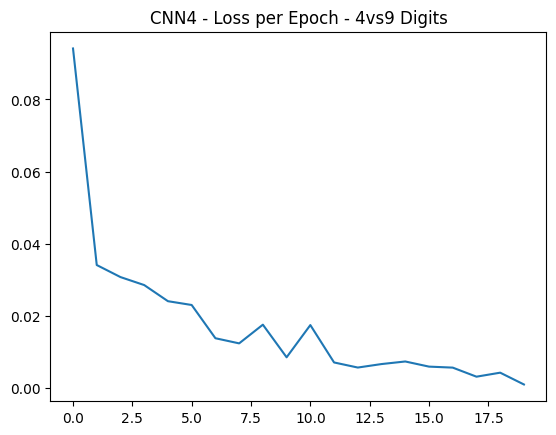

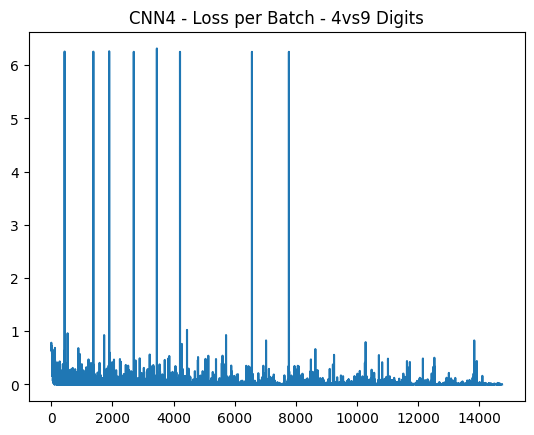

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((2,2), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params
    label = int(label.item())
    # print(label)
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    prediction = int(prediction.round().cpu().item())
    # print(prediction)
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

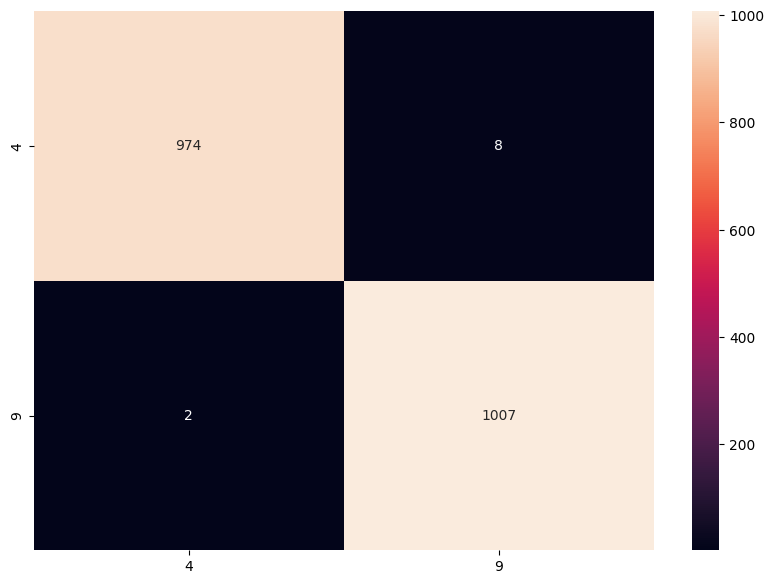

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "49"],
                  columns = [i for i in "49"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9949773982923155

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9949760181196429

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9950345231365583

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9949355999668967

#### **3 vs 8 Digit Classification**

In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

idx1 = train.targets==3
idx2 = train.targets==8
idx = torch.logical_or(idx1, idx2)

print("Binary Encode the two digits")

train_y = train.targets[idx]
print(train_y)
encoder = LabelEncoder()
encoder.fit(train_y)

train_y = encoder.transform(train_y)
train.targets = torch.from_numpy(train_y)
train.data = train.data[idx]

idx1 = test.targets==3
idx2 = test.targets==8
idx = torch.logical_or(idx1, idx2)

test_y = test.targets[idx]
print(test_y)
test_y = encoder.transform(test_y)
test.targets = torch.from_numpy(test_y)
test.data = test.data[idx]

print(train.targets)
print(test.targets)

Binary Encode the two digits
tensor([3, 3, 3,  ..., 8, 3, 8])
tensor([3, 3, 3,  ..., 3, 8, 3])
tensor([0, 0, 0,  ..., 1, 0, 1])
tensor([0, 0, 0,  ..., 0, 1, 0])


In [ ]:
input_channel_size = 1 # just 1 channel for MNIST because it's Black and White images (Grayscale)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4Binary(input_channel_size)
model.to(device)

CNN4Binary(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss() # Binary Cross Entropy

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        labels = labels.reshape(-1, 1).to(dtype=torch.float)
        # print(labels)

        # lets predict (forward pass)
        prediction = model(samples)
        # print(prediction)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.07495548033039183
Epoch: 2 Loss: 0.018491950659120706
Epoch: 3 Loss: 0.009846333195364834
Epoch: 4 Loss: 0.010019920755678447
Epoch: 5 Loss: 0.007422008495443764
Epoch: 6 Loss: 0.005971583974663926
Epoch: 7 Loss: 0.0034655853699197777
Epoch: 8 Loss: 0.004860113860160055
Epoch: 9 Loss: 0.002016975913006355
Epoch: 10 Loss: 0.006638983373048959
Epoch: 11 Loss: 0.0019119108569150144
Epoch: 12 Loss: 0.0037986704599194854
Epoch: 13 Loss: 0.0027066757025336775
Epoch: 14 Loss: 0.0002184010872068291
Epoch: 15 Loss: 0.00012461689310324902
Epoch: 16 Loss: 0.004901898183302365
Epoch: 17 Loss: 0.0035125296789777103
Epoch: 18 Loss: 0.0009713687266108408
Epoch: 19 Loss: 0.0005649189473358287
Epoch: 20 Loss: 0.0006348479207698669
Training Time: 0:00:53.237670


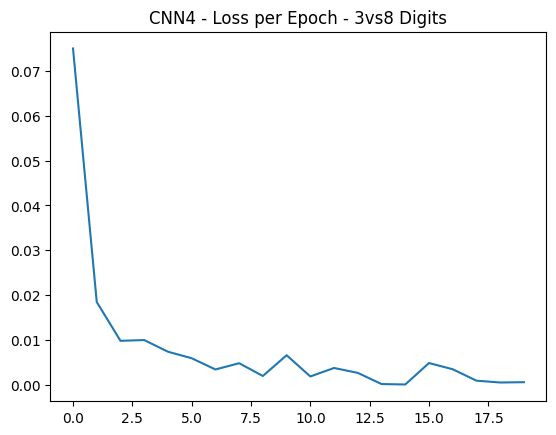

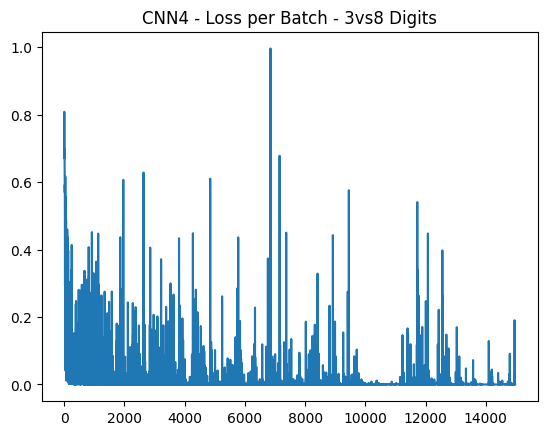

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((2,2), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params
    label = int(label.item())
    # print(label)
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    prediction = int(prediction.round().cpu().item())
    # print(prediction)
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

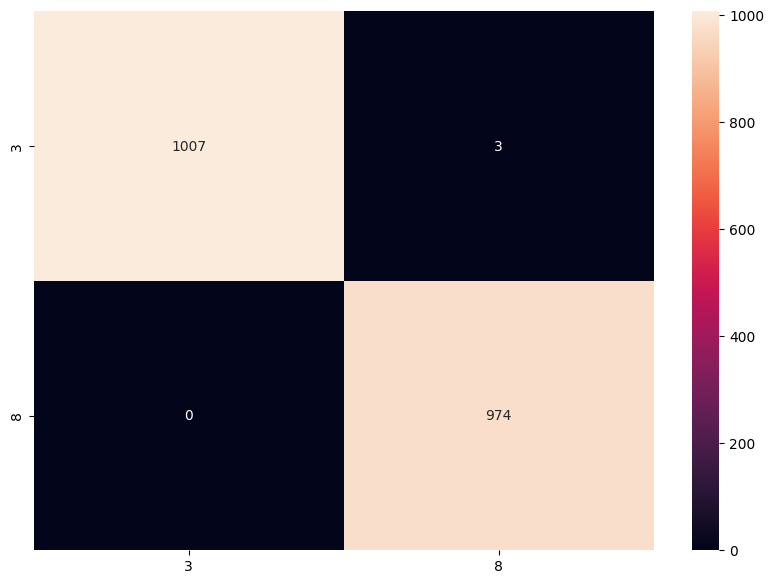

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "38"],
                  columns = [i for i in "38"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9984879032258065

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9984874847751062

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9984646878198566

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9985148514851485

### Worst Model - RBF50 - Binary Implementation

In [ ]:
class RBFnetBinary(nn.Module):
    def __init__(self, clusters, device):
        super(RBFnetBinary, self).__init__()
        # remember how many centers we have
        self.N = clusters.shape[0]
        # our mean and sigmas for the RBF layer
        self.sigs = nn.Parameter( torch.ones(self.N, dtype=torch.float64, device=device)*5, requires_grad=False) # our sigmas
        self.mus = nn.Parameter( torch.from_numpy(clusters).to(device), requires_grad=False) # our means
        self.linear = nn.Linear(self.N, 1, dtype=torch.float64)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Non-Vectorized Version - Slow......... Because of the nested for loops..
        #-------------------------------------------------------------------------
        # you could do some matrix math and get rid of this for loop!!!!
        # res = torch.zeros(x.shape[0],self.N,dtype=torch.float64).to(device)
        # for i in range(x.shape[0]): # each data point
        #     for j in range(self.N): # each cluster
        #         top = torch.sqrt(((x[i,:]-self.mus[j,:])**2).sum(axis=0))
        #         res[i,j] = torch.exp( (-0.5) * ( torch.pow(top,2.0) / torch.pow(self.sigs[j],2.0) ) )
        # print(res.shape)
        # y_pred = torch.zeros(x.shape[0],dtype=torch.float64)
        # for i in range(x.shape[0]): # again, could speed up with matrix math!!!
        #     y_pred[i] = self.linear(res[i,:])
        
        # Vectorized Version - Pretty Fast
        #--------------------------------------------------------------------------
        size = (x.size(0), self.N, x.size(1)) # (batch_size, number_of_clusters or rbfs, input_image_size=28x28=784) 
        x = x.unsqueeze(1).expand(size)
        c = self.mus.unsqueeze(0).expand(size)
        top = (x - c).pow(2).sum(-1).pow(0.5)
        res = (-0.5*(top.pow(2) / self.sigs.pow(2))).exp()
        y_pred = self.sigmoid(self.linear(res))
        return y_pred

#### **5 vs 3 Digit Classification**



In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

idx1 = train.targets==5
idx2 = train.targets==3
idx = torch.logical_or(idx1, idx2)

print("Binary Encode the two digits")

train_y = train.targets[idx]
print(train_y)
encoder = LabelEncoder()
encoder.fit(train_y)

train_y = encoder.transform(train_y)
train.targets = torch.from_numpy(train_y)
train.data = train.data[idx]

idx1 = test.targets==5
idx2 = test.targets==3
idx = torch.logical_or(idx1, idx2)

test_y = test.targets[idx]
print(test_y)
test_y = encoder.transform(test_y)
test.targets = torch.from_numpy(test_y)
test.data = test.data[idx]

print(train.targets)
print(test.targets)

Binary Encode the two digits
tensor([5, 3, 3,  ..., 5, 3, 5])
tensor([5, 5, 3,  ..., 5, 3, 5])
tensor([1, 0, 0,  ..., 1, 0, 1])
tensor([1, 1, 0,  ..., 1, 0, 1])


In [ ]:
number_of_rbf = 50

In [ ]:
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kmeans = KMeans(n_clusters=number_of_rbf, distance="euclidean")
x = torch.from_numpy(xtrain.T).to(device)
y = torch.from_numpy(ytrain.T).to(device)
kmeans.fit(x.contiguous())
clusters = kmeans.centroids.T.cpu().numpy()
print(clusters.shape)

(50, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnetBinary(clusters, device)
model.to(device)

RBFnetBinary(
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss() # Binary Cross Entropy

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf50_batch_loss = []
rbf50_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        labels = labels.reshape(-1, 1).to(dtype=torch.float64)
        # print(labels)

        # lets predict (forward pass)
        prediction = model(samples.view(len(labels), -1))
        # print(prediction)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf50_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf50_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.5889825265627128
Epoch: 2 Loss: 0.4779162880463327
Epoch: 3 Loss: 0.41193526254901286
Epoch: 4 Loss: 0.3661933019922953
Epoch: 5 Loss: 0.332555274215384
Epoch: 6 Loss: 0.3063086645783316
Epoch: 7 Loss: 0.28521705336163766
Epoch: 8 Loss: 0.2680365928910755
Epoch: 9 Loss: 0.25387078024453
Epoch: 10 Loss: 0.24205121558968928
Epoch: 11 Loss: 0.23177066416981096
Epoch: 12 Loss: 0.22295014804609609
Epoch: 13 Loss: 0.21533246036861836
Epoch: 14 Loss: 0.20879011521616966
Epoch: 15 Loss: 0.2028106265936013
Epoch: 16 Loss: 0.19776276182291055
Epoch: 17 Loss: 0.1929360930824645
Epoch: 18 Loss: 0.18875828465757316
Epoch: 19 Loss: 0.18490918026863076
Epoch: 20 Loss: 0.18139970032369085
Training Time: 0:00:34.442634


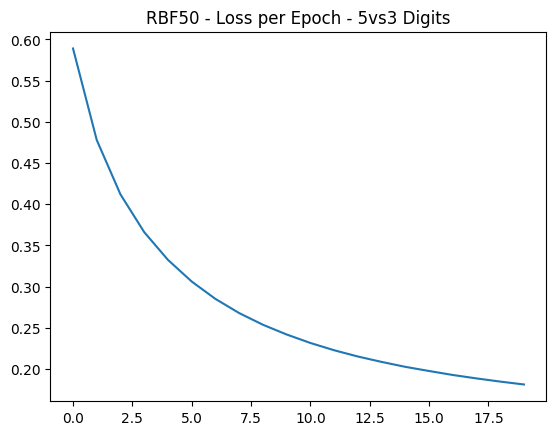

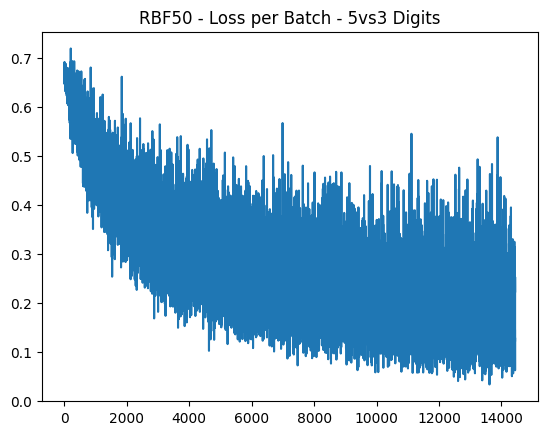

In [ ]:
plt.plot(rbf30_epoch_loss)
plt.title("RBF30 - Loss per Epoch")
plt.show()
plt.plot(rbf30_batch_loss)
plt.title("RBF30 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((2,2), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params
    label = int(label.item())
    # print(label)
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    prediction = int(prediction.round().cpu().item())
    # print(prediction)
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

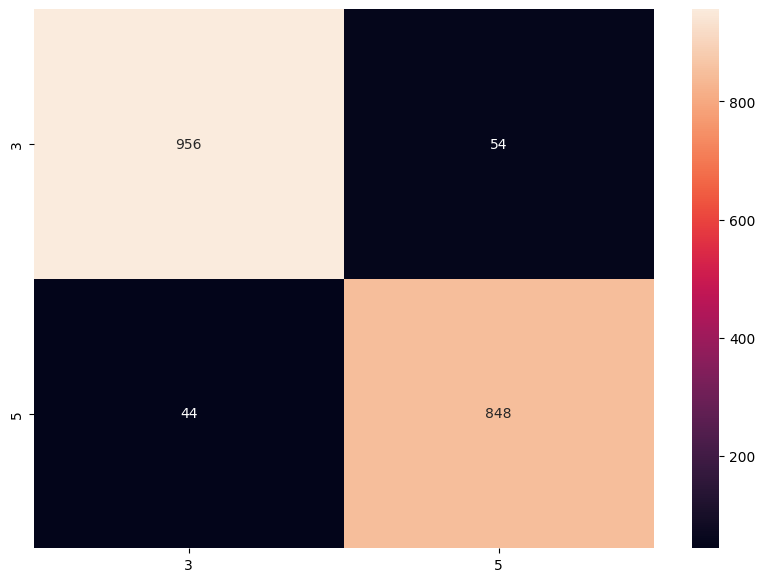

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "35"],
                  columns = [i for i in "35"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9484752891692955

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9483086241035625

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9480665188470067

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9486036496026284

#### **4 vs 9 Digit Classification**

In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

idx1 = train.targets==4
idx2 = train.targets==9
idx = torch.logical_or(idx1, idx2)

print("Binary Encode the two digits")

train_y = train.targets[idx]
print(train_y)
encoder = LabelEncoder()
encoder.fit(train_y)

train_y = encoder.transform(train_y)
train.targets = torch.from_numpy(train_y)
train.data = train.data[idx]

idx1 = test.targets==4
idx2 = test.targets==9
idx = torch.logical_or(idx1, idx2)

test_y = test.targets[idx]
print(test_y)
test_y = encoder.transform(test_y)
test.targets = torch.from_numpy(test_y)
test.data = test.data[idx]

print(train.targets)
print(test.targets)

Binary Encode the two digits
tensor([4, 9, 4,  ..., 4, 9, 9])
tensor([4, 4, 9,  ..., 4, 9, 4])
tensor([0, 1, 0,  ..., 0, 1, 1])
tensor([0, 0, 1,  ..., 0, 1, 0])


In [ ]:
number_of_rbf = 50

In [ ]:
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kmeans = KMeans(n_clusters=number_of_rbf, distance="euclidean")
x = torch.from_numpy(xtrain.T).to(device)
y = torch.from_numpy(ytrain.T).to(device)
kmeans.fit(x.contiguous())
clusters = kmeans.centroids.T.cpu().numpy()
print(clusters.shape)

(50, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnetBinary(clusters, device)
model.to(device)

RBFnetBinary(
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss() # Binary Cross Entropy

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf50_batch_loss = []
rbf50_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        labels = labels.reshape(-1, 1).to(dtype=torch.float64)
        # print(labels)

        # lets predict (forward pass)
        prediction = model(samples.view(len(labels), -1))
        # print(prediction)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf50_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf50_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.6485063127195678
Epoch: 2 Loss: 0.5731929351068037
Epoch: 3 Loss: 0.5205448992309224
Epoch: 4 Loss: 0.47929951652336467
Epoch: 5 Loss: 0.44516482413368896
Epoch: 6 Loss: 0.4172159408385462
Epoch: 7 Loss: 0.3929083834455925
Epoch: 8 Loss: 0.3721431980188723
Epoch: 9 Loss: 0.3538495443078324
Epoch: 10 Loss: 0.3379291233439342
Epoch: 11 Loss: 0.32383777198426683
Epoch: 12 Loss: 0.31121669209868624
Epoch: 13 Loss: 0.30007766136410674
Epoch: 14 Loss: 0.28983756142044587
Epoch: 15 Loss: 0.2808743106354081
Epoch: 16 Loss: 0.2727822729403299
Epoch: 17 Loss: 0.2652347271497421
Epoch: 18 Loss: 0.25863305425768757
Epoch: 19 Loss: 0.25247141480868013
Epoch: 20 Loss: 0.24657129768462882
Training Time: 0:00:31.183221


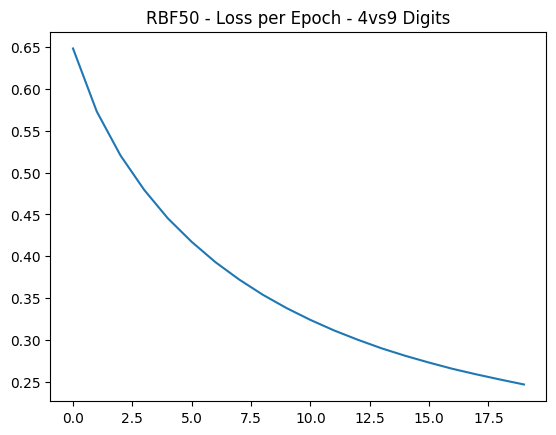

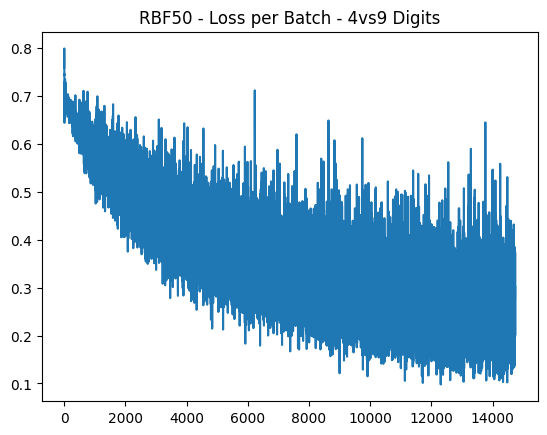

In [ ]:
plt.plot(rbf30_epoch_loss)
plt.title("RBF30 - Loss per Epoch")
plt.show()
plt.plot(rbf30_batch_loss)
plt.title("RBF30 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((2,2), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params
    label = int(label.item())
    # print(label)
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    prediction = int(prediction.round().cpu().item())
    # print(prediction)
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

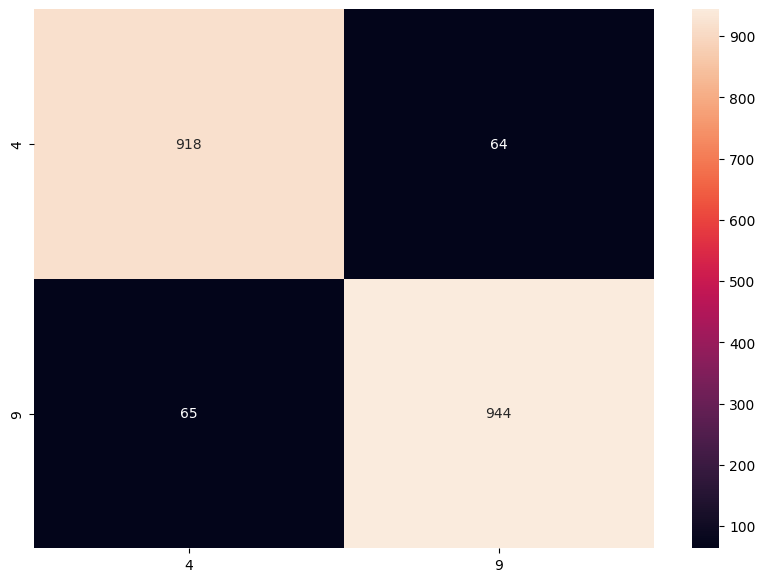

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "49"],
                  columns = [i for i in "49"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9352084379708689

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9351973870951871

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9351919133200923

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9352033329363629

#### **3 vs 8 Digit Classification**

In [ ]:
train = datasets.MNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.MNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

idx1 = train.targets==3
idx2 = train.targets==8
idx = torch.logical_or(idx1, idx2)

print("Binary Encode the two digits")

train_y = train.targets[idx]
print(train_y)
encoder = LabelEncoder()
encoder.fit(train_y)

train_y = encoder.transform(train_y)
train.targets = torch.from_numpy(train_y)
train.data = train.data[idx]

idx1 = test.targets==3
idx2 = test.targets==8
idx = torch.logical_or(idx1, idx2)

test_y = test.targets[idx]
print(test_y)
test_y = encoder.transform(test_y)
test.targets = torch.from_numpy(test_y)
test.data = test.data[idx]

print(train.targets)
print(test.targets)

Binary Encode the two digits
tensor([3, 3, 3,  ..., 8, 3, 8])
tensor([3, 3, 3,  ..., 3, 8, 3])
tensor([0, 0, 0,  ..., 1, 0, 1])
tensor([0, 0, 0,  ..., 0, 1, 0])


In [ ]:
number_of_rbf = 50

In [ ]:
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kmeans = KMeans(n_clusters=number_of_rbf, distance="euclidean")
x = torch.from_numpy(xtrain.T).to(device)
y = torch.from_numpy(ytrain.T).to(device)
kmeans.fit(x.contiguous())
clusters = kmeans.centroids.T.cpu().numpy()
print(clusters.shape)

(50, 784)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnetBinary(clusters, device)
model.to(device)

RBFnetBinary(
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss() # Binary Cross Entropy

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf50_batch_loss = []
rbf50_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        labels = labels.reshape(-1, 1).to(dtype=torch.float64)
        # print(labels)

        # lets predict (forward pass)
        prediction = model(samples.view(len(labels), -1))
        # print(prediction)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf50_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf50_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 0.5513917520060302
Epoch: 2 Loss: 0.41164881773041023
Epoch: 3 Loss: 0.34828714772007446
Epoch: 4 Loss: 0.3126677966666547
Epoch: 5 Loss: 0.2888682668727661
Epoch: 6 Loss: 0.27154071161957144
Epoch: 7 Loss: 0.2579917573116006
Epoch: 8 Loss: 0.2470023350851441
Epoch: 9 Loss: 0.23782063301561668
Epoch: 10 Loss: 0.23013807384590843
Epoch: 11 Loss: 0.22338049262493875
Epoch: 12 Loss: 0.21730364484054376
Epoch: 13 Loss: 0.21193686036755893
Epoch: 14 Loss: 0.20705600750641584
Epoch: 15 Loss: 0.20252552285237954
Epoch: 16 Loss: 0.19862355334849516
Epoch: 17 Loss: 0.19467316323367867
Epoch: 18 Loss: 0.19133598410895325
Epoch: 19 Loss: 0.18799687287104888
Epoch: 20 Loss: 0.1849246264108501
Training Time: 0:00:31.341804


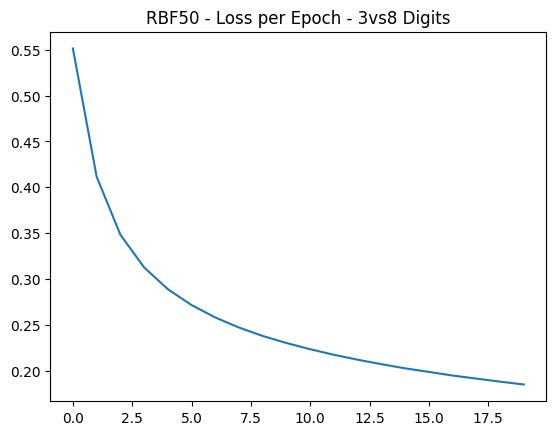

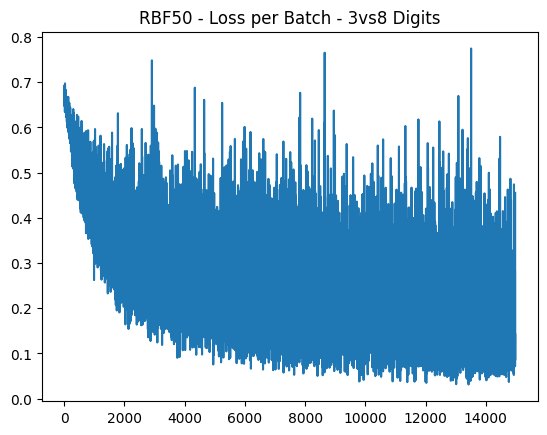

In [ ]:
plt.plot(rbf30_epoch_loss)
plt.title("RBF30 - Loss per Epoch")
plt.show()
plt.plot(rbf30_batch_loss)
plt.title("RBF30 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((2,2), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params
    label = int(label.item())
    # print(label)
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    prediction = int(prediction.round().cpu().item())
    # print(prediction)
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

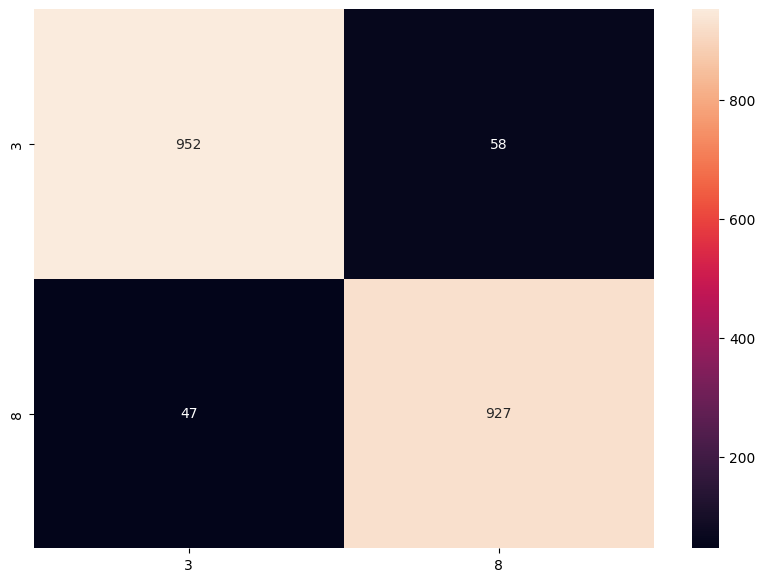

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "38"],
                  columns = [i for i in "38"], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.9470766129032258

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.9470682083762425

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.9470348521109941

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.9471598186512696

## CIFAR100 Dataset. 100 Classes!

In [ ]:
train = datasets.CIFAR100( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

test = datasets.CIFAR100( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train.data.shape)

(50000, 32, 32, 3)


In [ ]:
print(test.data.shape)

(10000, 32, 32, 3)


There are 50000 training and 10000 images of each 32x32x3 pixels in size. Since it's RGB image, it has 3 channels.

In [ ]:
print("what is the type and minmax values of the unprocessed MNIST data?")
print(torch.max(torch.from_numpy(train.data[0])))
print(torch.min(torch.from_numpy(train.data[0])))

what is the type and minmax values of the unprocessed MNIST data?
tensor(255, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)


In [ ]:
print("what is the type and minmax values of the processed(ToTensor() transform) MNIST data?")
print(torch.max(train[0][0]))
print(torch.min(train[0][0]))

what is the type and minmax values of the processed(ToTensor() transform) MNIST data?
tensor(1.)
tensor(0.0039)


We can see that the original images are of integer type with values ranging from 0 to 255. When loading the dataset, we have the normalized the values to floating type values ranging from 0.0 to 1.0 using the `torchvision.transforms.ToTensor()` transform.

Now, Let's visualize the first 10 images and their respective ground truth labels from the training dataset.

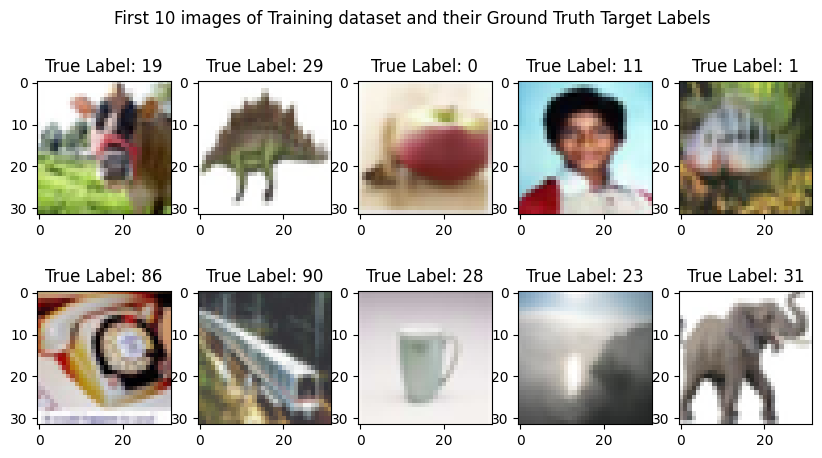

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("First 10 images of Training dataset and their Ground Truth Target Labels")
for i, ax in enumerate(axs.ravel()):
    ax.set_title("True Label: " + str(train.targets[i]))
    ax.imshow(train.data[i])

That's interesting to see. 32x32 pixels seems a bit blurry, but probably enough to identify the objects?

Let's see the number of classes and how many occurences of each in the training and test dataset.

In [ ]:
np.unique(train.targets, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 5

In [ ]:
np.unique(test.targets, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 1

So, there are 100 different classes present. The test set seems to be balanced with each class having 100 samples. The train set is also balanced with each class having 500 samples. I think the training and test datasets are well balanced and we are good to go. Let's start the training!

## Experiment 5: Will our models still do well? Let's try experiment 1 on this dataset and compare how it performance.

#### **MLP4 - CIFAR100**

In [ ]:
class MultiLayerPerceptron4(nn.Module):   
    def __init__(self, input_size, num_classes):
        super(MultiLayerPerceptron4, self).__init__()

        self.MLP = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.MLP(x)

In [ ]:
input_size = 32 * 32 * 3 # CIFAR pixel dimension
num_classes = 100 # we have 100 classes in CIFAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerPerceptron4(input_size, num_classes) 
model.to(device)
model.train()

MultiLayerPerceptron4(
  (MLP): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=100, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
mlp4_batch_loss = []
mlp4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        mlp4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    mlp4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 4.188707399139404
Epoch: 2 Loss: 3.9110227656555177
Epoch: 3 Loss: 3.7824388549804686
Epoch: 4 Loss: 3.685114035949707
Epoch: 5 Loss: 3.614534980773926
Epoch: 6 Loss: 3.564689468536377
Epoch: 7 Loss: 3.515765062713623
Epoch: 8 Loss: 3.4831072426605223
Epoch: 9 Loss: 3.4557656872558593
Epoch: 10 Loss: 3.43330232460022
Epoch: 11 Loss: 3.412500657043457
Epoch: 12 Loss: 3.392485494003296
Epoch: 13 Loss: 3.37862833404541
Epoch: 14 Loss: 3.361513288040161
Epoch: 15 Loss: 3.3449437550354
Epoch: 16 Loss: 3.3329784268951417
Epoch: 17 Loss: 3.3232338494873046
Epoch: 18 Loss: 3.3122691732788088
Epoch: 19 Loss: 3.3089600203704834
Epoch: 20 Loss: 3.2982861151123046
Training Time: 0:03:21.013995


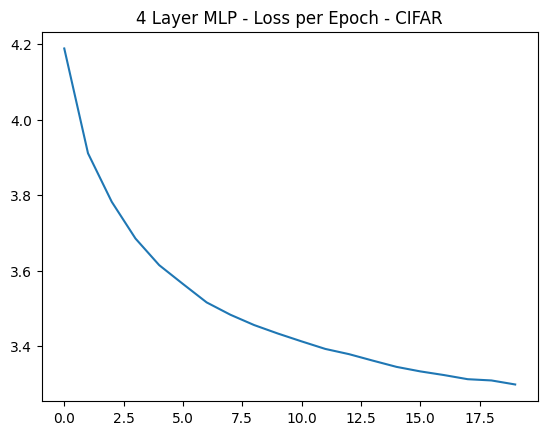

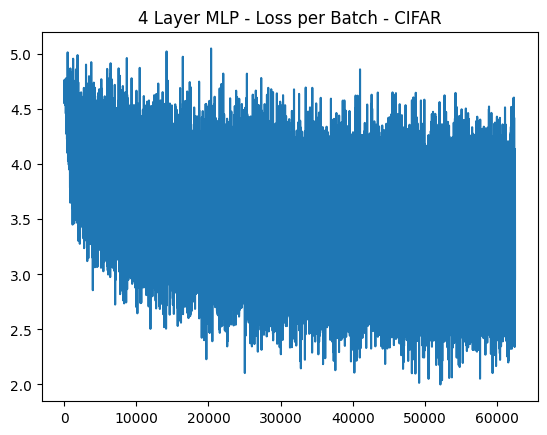

In [ ]:
plt.plot(mlp4_epoch_loss)
plt.title("4 Layer MLP - Loss per Epoch")
plt.show()
plt.plot(mlp4_batch_loss)
plt.title("4 Layer MLP - Loss per Batch")
plt.show()

Let's evaluate the performance of the model against the test dataset

In [ ]:
model.eval()
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((100,100), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

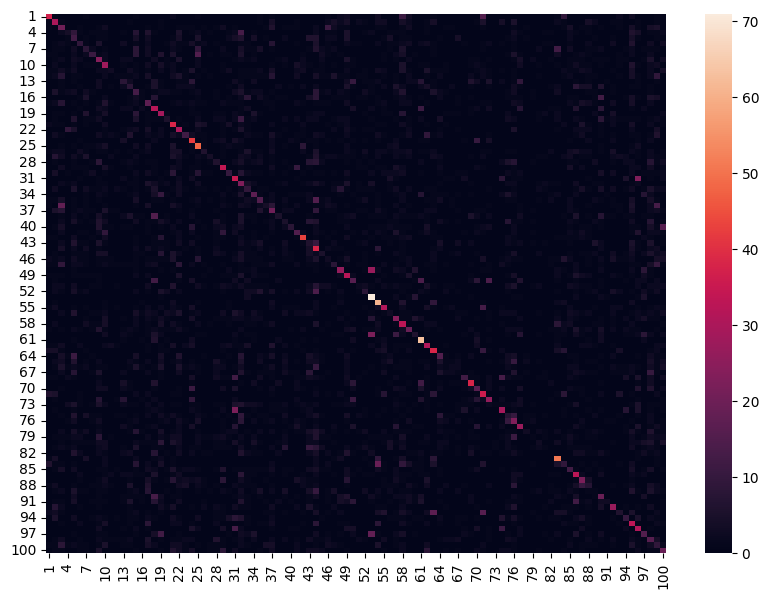

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [str(i) for i in range(1,101)],
                  columns = [str(i) for i in range(1,101)], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.1818

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.16207679916480472

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.17569639740996945

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.1818

#### **RBF 2 Layer - CIFAR100**

In [ ]:
number_of_rbf1 = 1000
num_layer1_linear_nodes = 750
number_of_rbf2 = 500
num_classes = 100 # we have 100 classes in CIFAR100

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xtrain = []
ytrain = []
for i in range(0, len(train)):
    xtrain.append(train[i][0].squeeze().numpy())
    ytrain.append(train[i][1])
xtrain = np.array(xtrain).reshape(len(xtrain),-1)
ytrain = np.array(ytrain)
x = torch.from_numpy(xtrain.T).to(device).contiguous()
y = torch.from_numpy(ytrain.T).to(device).contiguous()

In [ ]:
kmeans = KMeans(n_clusters=number_of_rbf1, distance="euclidean")
kmeans.fit(x)
clusters1 = kmeans.centroids.T.cpu().numpy()
print(clusters1.shape)

(1000, 3072)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBFnet2Layer(clusters1, num_layer1_linear_nodes, number_of_rbf2, num_classes, device)
model.to(device)

RBFnet2Layer(
  (linear1): Linear(in_features=1000, out_features=750, bias=True)
  (linear2): Linear(in_features=500, out_features=100, bias=True)
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
rbf_batch_loss = []
rbf_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)
        
        # print(samples.view(batch_size, -1).shape)

        # lets predict (forward pass)
        prediction = model(samples.view(batch_size, -1))
        # print(prediction.shape)
        # print(prediction)
        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        rbf_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    rbf_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 4.593394560310191
Epoch: 2 Loss: 4.508942478587599
Epoch: 3 Loss: 4.474067715615659
Epoch: 4 Loss: 4.4254296936409165
Epoch: 5 Loss: 4.357447136921414
Epoch: 6 Loss: 4.275271220140459
Epoch: 7 Loss: 4.2105290935607185
Epoch: 8 Loss: 4.1733657807224365
Epoch: 9 Loss: 4.133200342807338
Epoch: 10 Loss: 4.083841865286594
Epoch: 11 Loss: 4.039805455648399
Epoch: 12 Loss: 3.9982540124501207
Epoch: 13 Loss: 3.955176202628106
Epoch: 14 Loss: 3.915091654365393
Epoch: 15 Loss: 3.88259567114576
Epoch: 16 Loss: 3.85661058370054
Epoch: 17 Loss: 3.8328188368387766
Epoch: 18 Loss: 3.8101540113665804
Epoch: 19 Loss: 3.7850392117336455
Epoch: 20 Loss: 3.762773640458093
Training Time: 0:11:17.111410


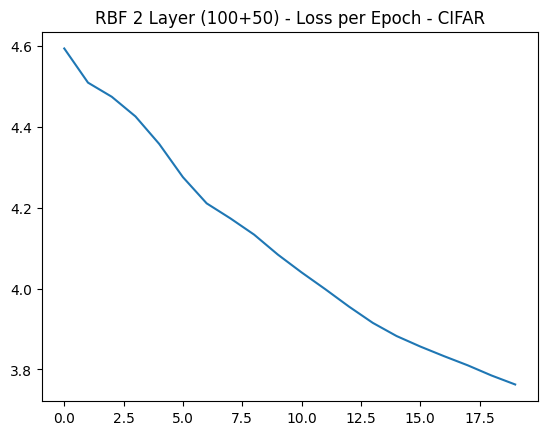

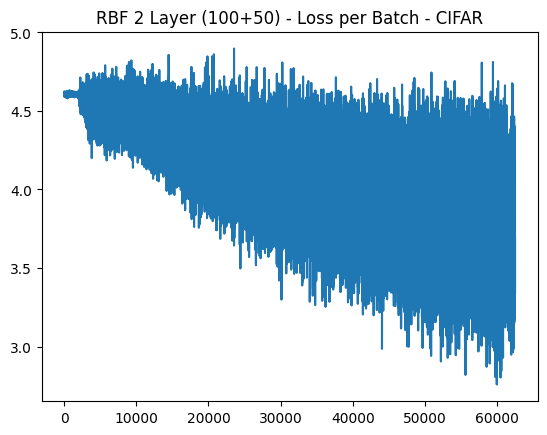

In [ ]:
plt.plot(rbf10_epoch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Epoch")
plt.show()
plt.plot(rbf10_batch_loss)
plt.title("RBF 2 Layer (100+50) - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((100,100), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample.view(1, -1)) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

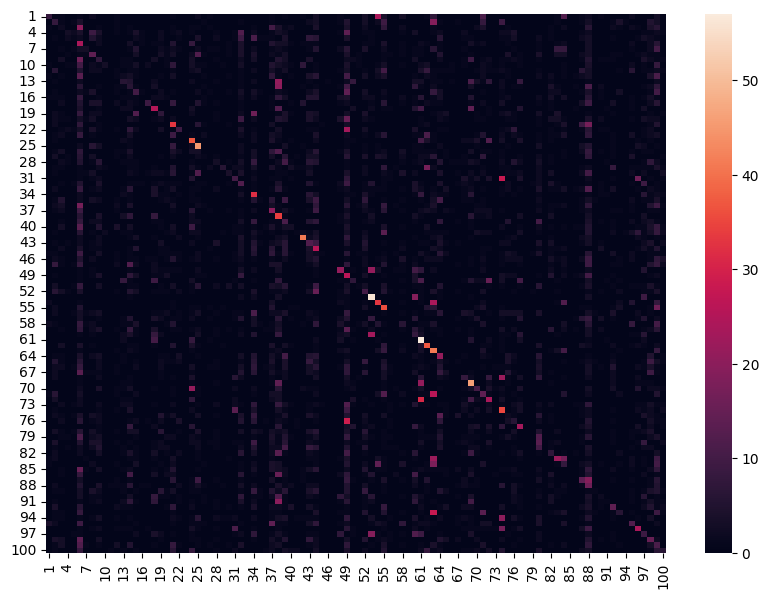

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [str(i) for i in range(1,101)],
                  columns = [str(i) for i in range(1,101)], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.1188

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.09661986465158057

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

/home/joeltech/micromamba/envs/nn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.12026533023002994

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.1188

#### **CNN4 - CIFAR100**

In [ ]:
class CNN4CIFAR(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNN4CIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 8, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            # Convolutional Layer 2
            nn.Conv2d( in_channels = 8, out_channels = 16, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            
            # Max Pool and Dropout
            nn.MaxPool2d(2), 
            nn.Dropout(0.1),

            # Convolutional Layer 3
            nn.Conv2d( in_channels = 16, out_channels = 32, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.Conv2d( in_channels = 32, out_channels = 64, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
        )
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(64*(16*16), num_classes), 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 3 # 3 channel for CIFAR100 because it's RGB Color images
num_classes = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN4CIFAR(input_channel_size, num_classes)
model.to(device)

CNN4CIFAR(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=16384, out_features=100, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 16
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 20
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 3.6520790991210936
Epoch: 2 Loss: 2.819180382270813
Epoch: 3 Loss: 2.3275178079605103
Epoch: 4 Loss: 1.9132454081344605
Epoch: 5 Loss: 1.532313913078308
Epoch: 6 Loss: 1.163518616156578
Epoch: 7 Loss: 0.8803317946398258
Epoch: 8 Loss: 0.6538099613511562
Epoch: 9 Loss: 0.5008222258597612
Epoch: 10 Loss: 0.4042316088490188
Epoch: 11 Loss: 0.3418306751778722
Epoch: 12 Loss: 0.30782793414473536
Epoch: 13 Loss: 0.27077007700171324
Epoch: 14 Loss: 0.25380408333068716
Epoch: 15 Loss: 0.23471149336155503
Epoch: 16 Loss: 0.216480715836538
Epoch: 17 Loss: 0.21086372906260192
Epoch: 18 Loss: 0.19637313543077559
Epoch: 19 Loss: 0.1890791977111809
Epoch: 20 Loss: 0.18083690919971093
Training Time: 0:04:02.873670


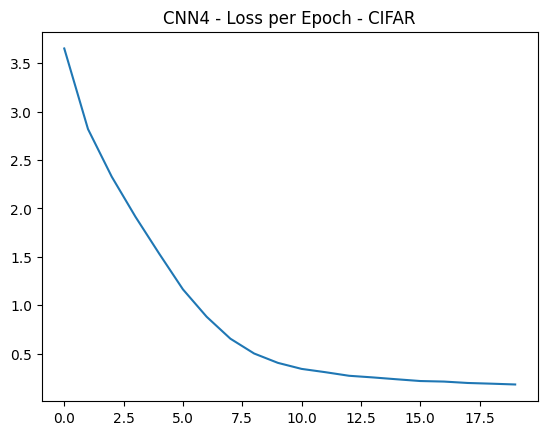

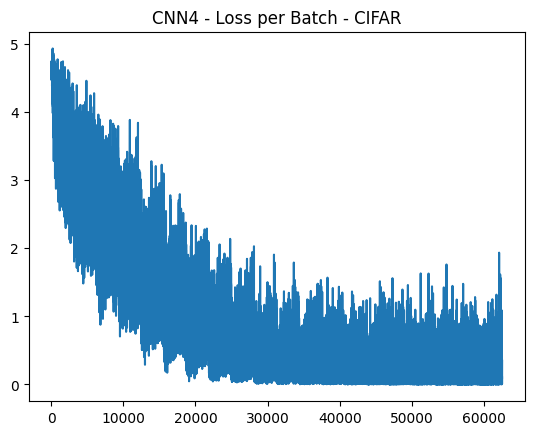

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((100,100), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

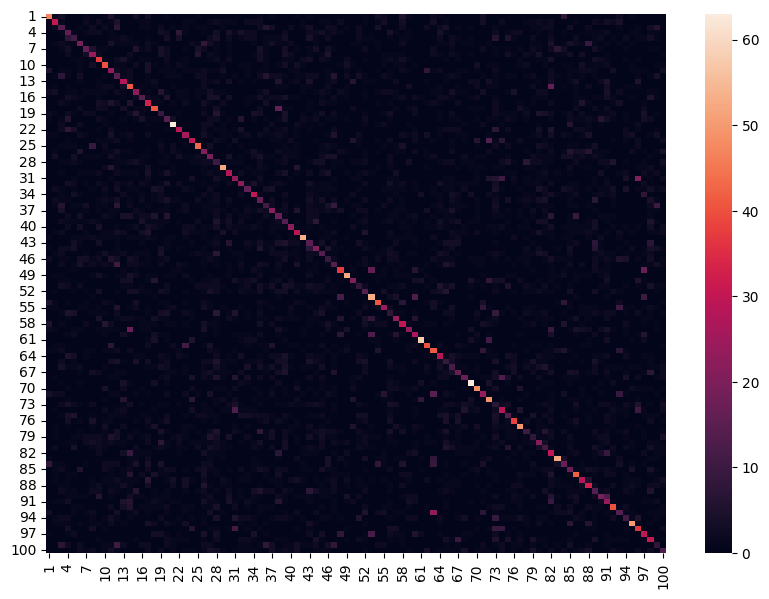

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [str(i) for i in range(1,101)],
                  columns = [str(i) for i in range(1,101)], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.2629

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.2648788588633765

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.2730947781576567

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.26289999999999997

Well, these are all still much much better than random prediction, like for binary classification, random prediction would be 1/2(50%), for 10 class classification like MNIST, it would be 1/10(10%), and for 100 class classification like CIFAR100, it would be 1/100(1%). Considering our models performing 25.5% accuracy means, it surely has learnt to classify these classes, but just not upto the level.

#### CNN - Advanced

This is not apple to apple comparision, we are going to take everything a notch up based on what we learnt so far and explore a bit too and see how far we can get.

In [ ]:
class CNNAdvanced(nn.Module):   
    def __init__(self, size, num_classes):
        super(CNNAdvanced, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d( in_channels = size, out_channels = 32, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2), 

            # Convolutional Layer 2
            nn.Conv2d( in_channels = 32, out_channels = 64, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2), 


            # Convolutional Layer 3
            nn.Conv2d( in_channels = 64, out_channels = 128, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),

            # Convolutional Layer 4
            nn.Conv2d( in_channels = 128, out_channels = 256, 
                     kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(inplace = True),
        )
        # Linear Layer Mapping CNN Output to Number of Classes
        self.linear = nn.Sequential(
            nn.Linear(256*(4*4), num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1) 
        return self.linear(x)

In [ ]:
input_channel_size = 3 # 3 channel for CIFAR100 because it's RGB Color images
num_classes = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNAdvanced(input_channel_size, num_classes)
model.to(device)

CNNAdvanced(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=4096, out_features=100, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 64
train_loader = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)

In [ ]:
start = datetime.now()
num_epochs = 75
count = 1
cnn4_batch_loss = []
cnn4_epoch_loss = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_loader):
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor').to(device)
        labels = labels.type('torch.LongTensor').to(device)

        # lets predict (forward pass)
        prediction = model(samples)

        # evaluate our error
        loss = loss_function(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        cnn4_batch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    cnn4_epoch_loss.append(epoch_loss)
    print("Epoch:", count, "Loss:", epoch_loss)
    count += 1
end = datetime.now()
print("Training Time:", end - start)

Epoch: 1 Loss: 3.71175875688148
Epoch: 2 Loss: 2.933678626404394
Epoch: 3 Loss: 2.509564868324553
Epoch: 4 Loss: 2.1935742364820006
Epoch: 5 Loss: 1.920123396474687
Epoch: 6 Loss: 1.672022737810374
Epoch: 7 Loss: 1.4425312631270464
Epoch: 8 Loss: 1.231671254348267
Epoch: 9 Loss: 1.0365530359927955
Epoch: 10 Loss: 0.8630715091438854
Epoch: 11 Loss: 0.7122488774530723
Epoch: 12 Loss: 0.580253856756803
Epoch: 13 Loss: 0.4878835397417588
Epoch: 14 Loss: 0.41801928319132237
Epoch: 15 Loss: 0.364447254277861
Epoch: 16 Loss: 0.3221399361158119
Epoch: 17 Loss: 0.27545759857386887
Epoch: 18 Loss: 0.2637014242027269
Epoch: 19 Loss: 0.2559512722999086
Epoch: 20 Loss: 0.24385809612310375
Epoch: 21 Loss: 0.21824020983370215
Epoch: 22 Loss: 0.21749485158325765
Epoch: 23 Loss: 0.2196665156508803
Epoch: 24 Loss: 0.1936508373254934
Epoch: 25 Loss: 0.20231397268707718
Epoch: 26 Loss: 0.19315900097784522
Epoch: 27 Loss: 0.18421912760190343
Epoch: 28 Loss: 0.1883314501665666
Epoch: 29 Loss: 0.189240157427

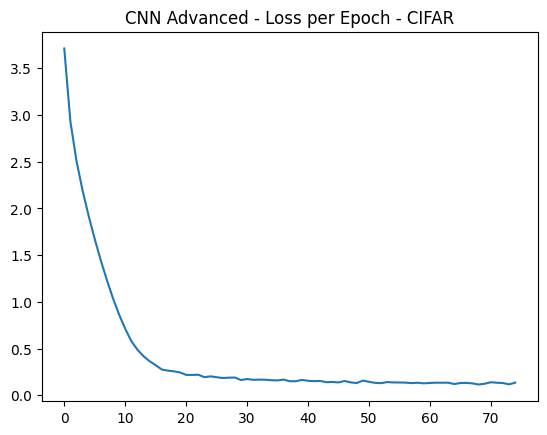

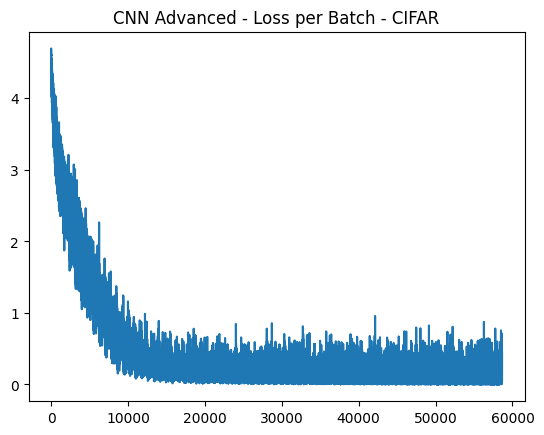

In [ ]:
plt.plot(cnn4_epoch_loss)
plt.title("CNN4 - Loss per Epoch")
plt.show()
plt.plot(cnn4_batch_loss)
plt.title("CNN4 - Loss per Batch")
plt.show()

In [ ]:
test_loader = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1)

ConfusionMatrix = torch.zeros((100,100), dtype=torch.int)
label_true = []
label_pred = []
for batch_id, test_params in enumerate(test_loader):
    sample, label = test_params

    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor').to(device)
    
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).cpu().numpy())
    
    label_true.append(label)
    label_pred.append(prediction)
    
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

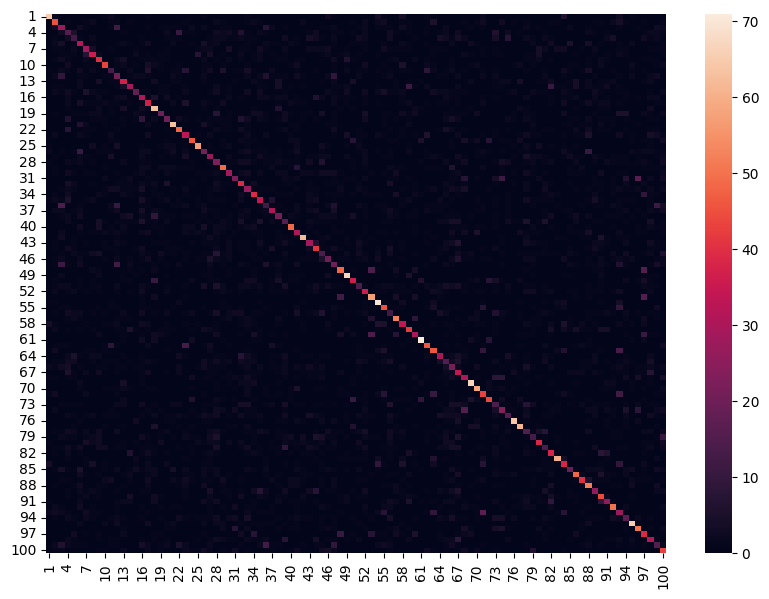

In [ ]:
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [str(i) for i in range(1,101)],
                  columns = [str(i) for i in range(1,101)], dtype=int)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='g')
plt.show()

In [ ]:
metrics.accuracy_score(label_true, label_pred)

0.3572

In [ ]:
metrics.f1_score(label_true, label_pred, average='macro')

0.3559452966100427

In [ ]:
metrics.precision_score(label_true, label_pred, average='macro')

0.3627324106272997

In [ ]:
metrics.recall_score(label_true, label_pred, average='macro')

0.35719999999999996